In [1]:
#default_exp verbatims/standard_themes_saw/training

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Standard S@W Themes - Training

> This module contains all the bits required to train and evaluate S@W standard theme models

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm

import optuna

from fastai.text.all import *
from transformers import *
from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from tritonlytics_ai.utils import *
from tritonlytics_ai.verbatims.core import *

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.6.0
Using fastai 2.0.16
Using transformers 3.3.1


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

In [8]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(STANDARD_THEME_SAW_LABELS)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

In [9]:
df = get_saw_standard_theme_train_data()
train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]

set_seed(TL_RAND_SEED)
dls = get_saw_standard_theme_train_dls(df, hf_arch, hf_tokenizer)

In [10]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 456]), torch.Size([8, 25]))

## Training

In [11]:
m_pre = f'exp_{m_pre_standard_themes_saw}'
m_suf = m_suf_standard_themes_saw
base_model_name = base_model_name_standard_themes_saw

Configure our **metrics**

In [12]:
# define metrics
beta, start, end, average, sample_weight = .5, 0.08, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

In [8]:
#export
def get_metrics(train_config={}):
    config = {**saw_standard_themes_train_config, **train_config}

    beta, average, sample_weight = config['opt_beta'], config['opt_beta_average'], config['opt_beta_sample_weight']
    start, end = config['opt_start'], config['opt_end']
    
    # fbeta and roc-auc metrics
    fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
    prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
    recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
    roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
    
    return [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

Configure our **loss**

In [14]:
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

In [15]:
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
# loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))
loss_func = BCEWithLogitsLossFlat()

In [9]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    if (use_weighted and train_df is not None):
        label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
        most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

        for lbl in label_counts: 
            label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]

        pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
        
        loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to(dls.device))
        loss_func.thresh = 0.5 # adding "thresh" since we want to optimize this for our target beta
    else:
        loss_func = BCEWithLogitsLossFlat()
        
    return loss_func

In [17]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), BCEWithLogitsLossFlat)

In [18]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), torch.nn.BCEWithLogitsLoss)
test_eq(len(tst_loss_func.pos_weight), dls.c)
test_eq(dls.device, tst_loss_func.pos_weight.device)

Configure our **callbacks**

In [19]:
best_model_cb = SaveModelCallback(monitor='precision_score', 
                                  comp=np.greater, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}{base_model_name}{m_suf}_bestmodel')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, 
                                            average=average, 
                                            sample_weight=sample_weight,
                                            start=start, end=end)

In [10]:
#export
def get_cbs(train_config={}, add_save_model_cb=True):
    config = {**saw_standard_themes_train_config, **train_config}
    fit_cbs = []
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=config['opt_beta'], 
                                                average=config['opt_beta_average'], 
                                                sample_weight=config['opt_beta_sample_weight'],
                                                start=config['opt_start'], end=config['opt_end'])
    
    if (add_save_model_cb): fit_cbs.append(best_model_cb)
    fit_cbs.append(opt_thresh_cb)
    
    return [HF_BaseModelCallback], fit_cbs # (learn_cbs, fit_cbs)

Configure our **Learner**

In [21]:
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [22]:
learn_metrics = [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

learn_cbs = [HF_BaseModelCallback]
fit_cbs = [best_model_cb, opt_thresh_cb]

# build learner
model = HF_BaseModelWrapper(hf_model)

set_seed(TL_RAND_SEED)
learn = Learner(dls, 
                model,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                loss_func=loss_func,
                metrics=learn_metrics,
                cbs=learn_cbs,
                splitter=hf_splitter,
                path=STANDARD_THEME_SAW_PATH)

learn.create_opt() # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [23]:
# learn.blurr_summary()

In [24]:
# learn.show_training_loop()

In [25]:
# Note: Run this to test the model and comment out afterwards as it needlessly contributes to GPU RAM utilization :(
# preds = model(b[0]); preds[0].shape

In [11]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                add_save_model_cb=True, train_config={}):
    config = {**saw_standard_themes_train_config, **train_config}
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config, add_save_model_cb=add_save_model_cb)
    learn_metrics = get_metrics(config)

    set_seed(TL_RAND_SEED)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

(0.002290867641568184, 0.0004786300996784121)

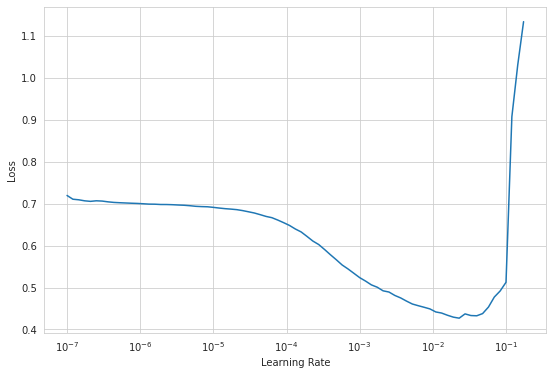

In [27]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [28]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(5, lr_max=lr_min, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.224361,0.216872,0.903771,0.317437,0.344206,0.403226,0.656665,0.180000,00:43
1,0.211863,0.196001,0.907886,0.372487,0.374415,0.453226,0.687245,0.190000,00:43
2,0.186754,0.186975,0.919200,0.422574,0.458391,0.450000,0.689452,0.260000,00:43
3,0.143057,0.175144,0.922857,0.450808,0.453964,0.477419,0.708357,0.330000,00:43
4,0.109196,0.173461,0.930286,0.466212,0.505590,0.390323,0.674051,0.430000,00:44


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.34420608431223143.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.3744147418624578.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with precision_score value: 0.45839077267622286.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 4 with precision_score value: 0.5055900485778181.


(3.311311274956097e-07, 1.5848931980144698e-06)

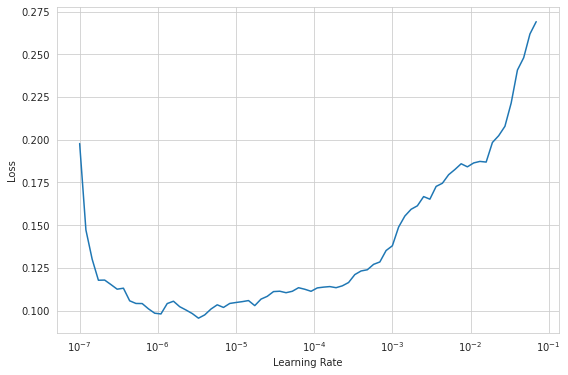

In [29]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [30]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(10, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.108896,0.173412,0.930286,0.465486,0.505308,0.388710,0.673271,0.430000,01:15
1,0.104305,0.173350,0.930743,0.468301,0.510068,0.387097,0.673104,0.430000,01:15
2,0.103626,0.173275,0.930743,0.467228,0.508276,0.385484,0.672459,0.430000,01:15
3,0.102417,0.173432,0.930057,0.466365,0.500337,0.396774,0.676965,0.420000,01:16
4,0.106965,0.173394,0.930286,0.465634,0.503693,0.388710,0.673471,0.430000,01:15
5,0.109062,0.173355,0.930743,0.466544,0.508122,0.382258,0.670991,0.440000,01:16
6,0.109199,0.173333,0.930857,0.466010,0.508439,0.379032,0.669653,0.440000,01:16
7,0.106366,0.173328,0.931428,0.466370,0.516672,0.367742,0.665220,0.450000,01:15
8,0.111459,0.173331,0.930400,0.465616,0.503444,0.388710,0.673501,0.430000,01:16
9,0.107521,0.173331,0.930400,0.465616,0.503444,0.388710,0.673501,0.430000,01:15


Better model found at epoch 1 with precision_score value: 0.5100678231352194.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 7 with precision_score value: 0.5166715983801744.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above as needed)

0.4299999999999998

In [32]:
learn.save(f'{m_pre}{base_model_name}{m_suf}')

Path('data/classification/standard_themes/saw/models/exp_verbatim_standard_theme_saw_multilabel_hf.pth')

Export model for inference

In [33]:
learn.export(fname=f'{m_pre}{base_model_name}{m_suf}_export.pkl')

Look at results

In [34]:
# have to add in the opthmize threshold cb since its used as *not* associated to the learner
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]]))); scores

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'valid_loss': 0.1733277291059494,
 'accuracy_multi': 0.9314283728599548,
 'fbeta_score': 0.4663697297422595,
 'precision_score': 0.5166715983801744,
 'recall_score': 0.36774193548387096,
 'roc_auc_score': 0.6652202124977817,
 'opt_th': 0.44999999999999984}

In [35]:
# learn.show_results(learner=learn, max_n=2) 
# => ERROR:Only one class present in y_true. ROC AUC score is not defined in that case.

Use it for inference

In [36]:
inf_learn = load_learner(STANDARD_THEME_SAW_PATH/f'{m_pre}{base_model_name}{m_suf}_export.pkl')

In [37]:
inf_learn.loss_func.thresh = scores['opt_th']
inf_learn.loss_func.thresh

0.44999999999999984

In [38]:
inf_learn.blurr_predict('We are not paid enough and the benefits are horrible')

((#2) ['benefits','salary_pay'],
 tensor([False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False]),
 tensor([5.7379e-03, 3.2889e-03, 2.1074e-03, 9.2408e-01, 8.1072e-04, 2.2800e-03,
         2.3897e-03, 4.1196e-04, 1.0702e-02, 9.6765e-03, 1.8001e-04, 3.4762e-04,
         2.4567e-03, 2.0843e-04, 2.4994e-01, 3.6274e-02, 2.6482e-03, 9.5563e-04,
         8.1444e-04, 1.6998e-03, 1.0364e-03, 1.2090e-02, 4.6767e-01, 5.9649e-03,
         1.1515e-02]))

Review final validation loss for best model

In [39]:
print(STANDARD_THEME_SAW_LABELS)

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions', 'career_advancement', 'committed_to_diversity', 'communicates_essential_information', 'ethical_conduct_perform_responsibilities_spirit_of_cooperation', 'evaluated_fairly', 'experienced_discrimination', 'facilities_workspace_safety', 'faculty_value_contributions', 'favoritism_cliques', 'fear_of_retaliation_negative_consequences', 'feel_valued_by_department', 'flexibility_work_life_balance', 'good_use_of_skills', 'have_necessary_tools', 'have_voice_within_my_institution_valued_member_of_my_institution', 'internal_processes_effective', 'parking_transportation', 'salary_pay', 'satisfied_with_diversity_progams', 'supervisor_effectiveness_resolves_staff_issues']


In [40]:
learn = learn.load(f'{m_pre}{base_model_name}{m_suf}_bestmodel')
learn.loss_func.thresh = scores['opt_th']
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.1733277589082718


In [41]:
learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued")

((#1) ['faculty_value_contributions'],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False]),
 tensor([2.3197e-02, 4.2792e-03, 2.2546e-03, 1.9551e-03, 2.3885e-01, 6.9983e-04,
         9.5010e-04, 1.1664e-03, 1.0040e-01, 6.9474e-04, 2.6726e-02, 8.5396e-04,
         5.5365e-01, 2.7017e-04, 3.0105e-03, 1.6688e-01, 2.4507e-04, 1.2071e-03,
         1.0861e-05, 2.4509e-02, 1.3461e-03, 2.8786e-03, 4.5551e-03, 1.7787e-02,
         1.0715e-02]))

## Review

In [42]:
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [43]:
# predictions for a single model using the learner's model and data loaders
set_seed(TL_RAND_SEED)
learn, fit_cbs = get_learner(hf_model, 
                             dls, 
                             train_df=train_df, 
                             use_weighted_loss=False, 
                             use_fp16=True,
                             train_config={})

learn = learn.load(f'{m_pre}{base_model_name}{m_suf}_bestmodel')
learn.loss_func.thresh = scores['opt_th']
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(torch.Size([350, 25]), torch.Size([350, 25]), 350, 25, 0.44999999999999984)

### Lets look at validation metrics

In [44]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [45]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.43000000000000005, 0.21000000000000002, 0.08000000000000002)

In [46]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.46606704981469954, 0.47656171059667957, 0.5995140314759746)

In [47]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f05), beta=.5, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.46606704981469954

In [48]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.930057168006897, 0.9079999923706055, 0.8482285737991333)

In [49]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f05).byte() == targs.byte()).float().mean()
preds.item()

0.930057168006897

### Overall metrics

In [50]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [51]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f05), sample_weight=sample_weight))

0.2257142857142857


In [52]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight))

0.9300571428571428


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [53]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 8130


In [54]:
most_freq_class_count / len(eval_targs)

0.9291428571428572

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [55]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.40498413291021096


#### Confusion Matrix

Describes the performance of a classification model

In [56]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [57]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

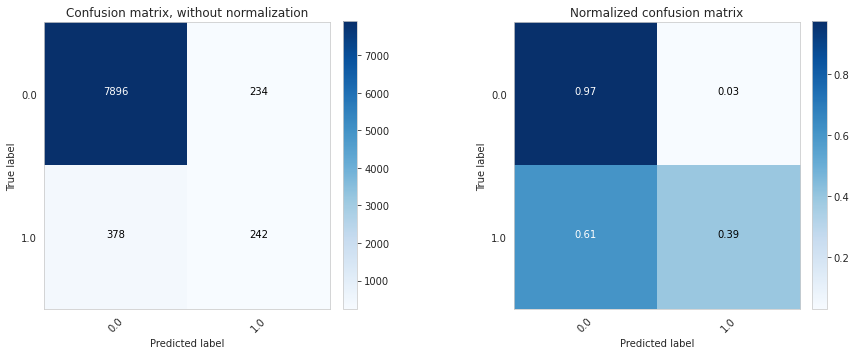

In [58]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [59]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f05).float(), sample_weight=sample_weight)

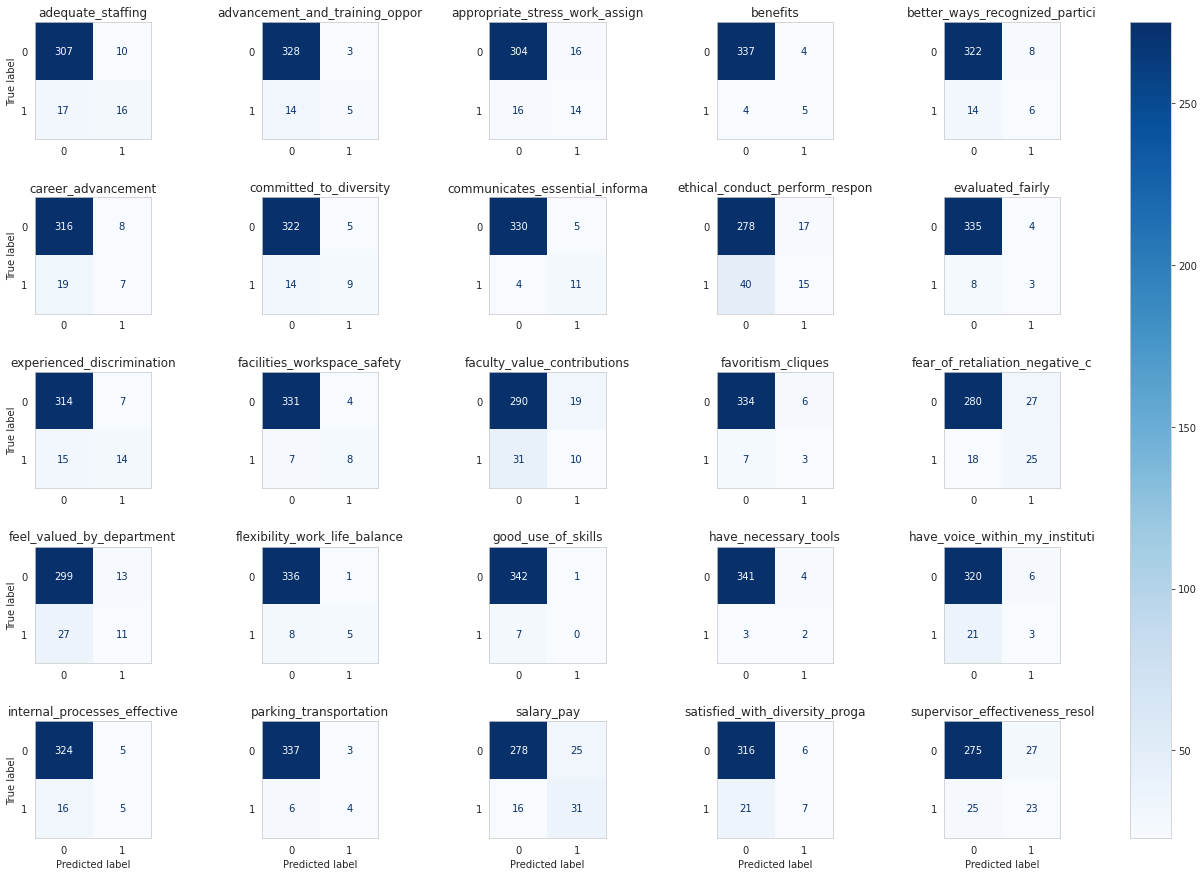

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(5, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(25):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(STANDARD_THEME_SAW_LABELS[i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.5)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [61]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8130
           1       0.51      0.39      0.44       620

    accuracy                           0.93      8750
   macro avg       0.73      0.68      0.70      8750
weighted avg       0.92      0.93      0.93      8750



In [62]:
classification_report = skm.classification_report(targs, (probs > threshold_f05).float(), 
                                target_names=STANDARD_THEME_SAW_LABELS,
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

,precision,recall,f1-score,support
adequate_staffing,0.615385,0.484848,0.542373,33.0
advancement_and_training_opportunities,0.625000,0.263158,0.370370,19.0
appropriate_stress_work_assigned_equitably,0.466667,0.466667,0.466667,30.0
benefits,0.555556,0.555556,0.555556,9.0
better_ways_recognized_participate_in_decisions,0.428571,0.300000,0.352941,20.0
career_advancement,0.466667,0.269231,0.341463,26.0
committed_to_diversity,0.642857,0.391304,0.486486,23.0
communicates_essential_information,0.687500,0.733333,0.709677,15.0
ethical_conduct_perform_responsibilities_spirit_of_cooperation,0.468750,0.272727,0.344828,55.0
evaluated_fairly,0.428571,0.272727,0.333333,11.0


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

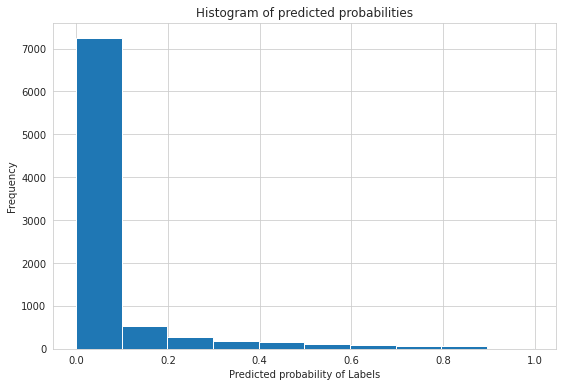

In [63]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Labels')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [64]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

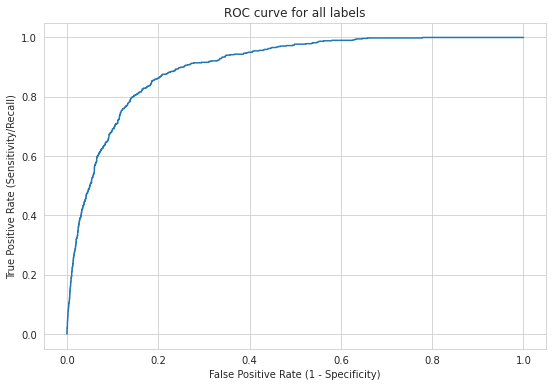

In [65]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [66]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.9033826330198785


### Let's look at things by label by label

In [67]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_SAW_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

In [68]:
# label_metrics

ADEQUATE_STAFFING

Null Accuracy:	0.9057142857142857
AUC Score:	0.895373291272345

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9228571428571428	0.8857142857142857	0.8114285714285714	
Cohen's Kappa:	0.500897855709306	0.41082400471340796	0.38225383751403974	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9475              0.9685              0.9579              317                 
1                   0.6154              0.4848              0.5424              33                  
avg/total           0.7815              0.7267              0.7501              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9511              0.9211              0.9359              317                 
1                   0.4186              0.5455              0.4737             

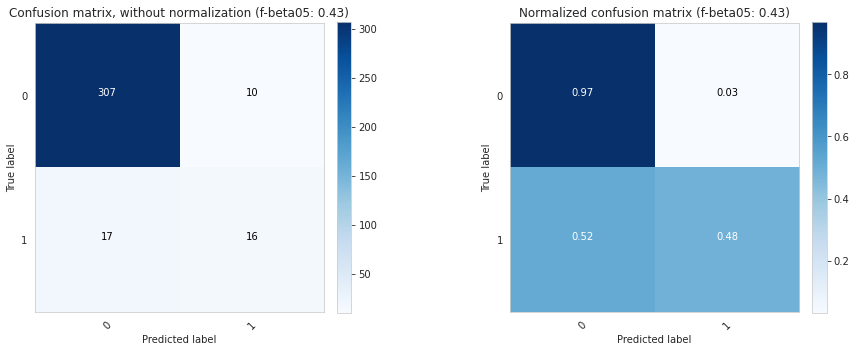

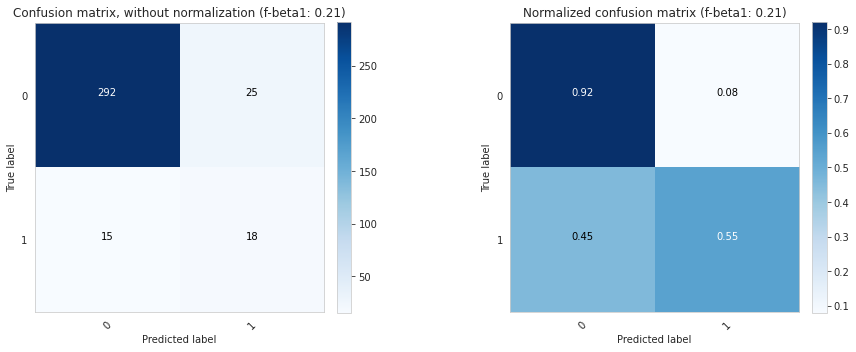

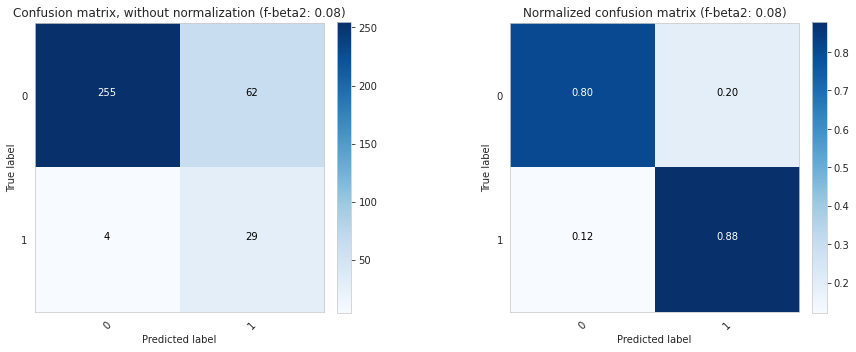



ROC Curve:


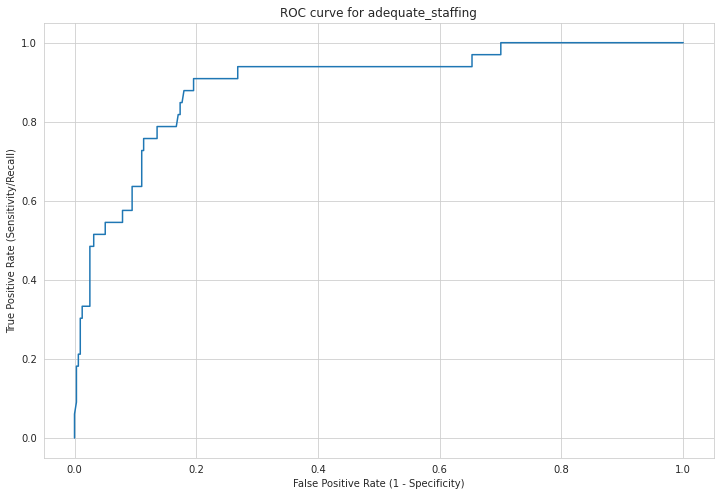

Predicted Probability Distribution:


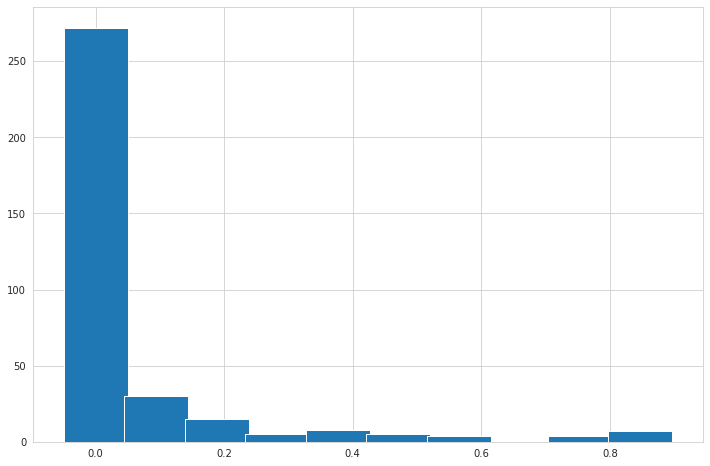



----------------------------------------------------------------------------------------------------


ADVANCEMENT_AND_TRAINING_OPPORTUNITIES

Null Accuracy:	0.9457142857142857
AUC Score:	0.858324057878836

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9514285714285714	0.94	0.8742857142857143	
Cohen's Kappa:	0.34944237918215615	0.5020999864517003	0.33580608988182525	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9591              0.9909              0.9747              331                 
1                   0.625               0.2632              0.3704              19                  
avg/total           0.792               0.627               0.6726              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9784              0.9577              0.9679 

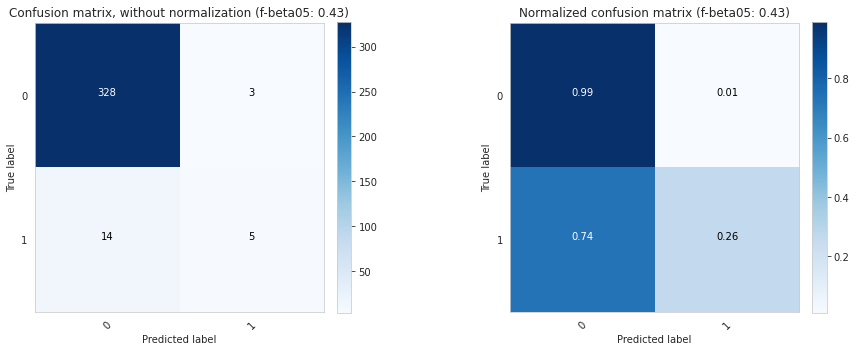

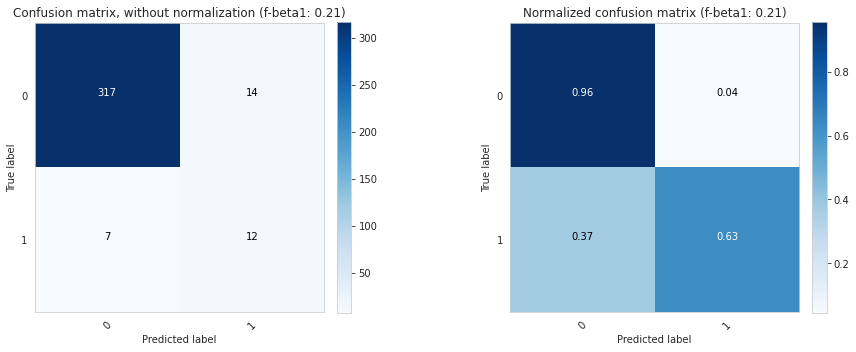

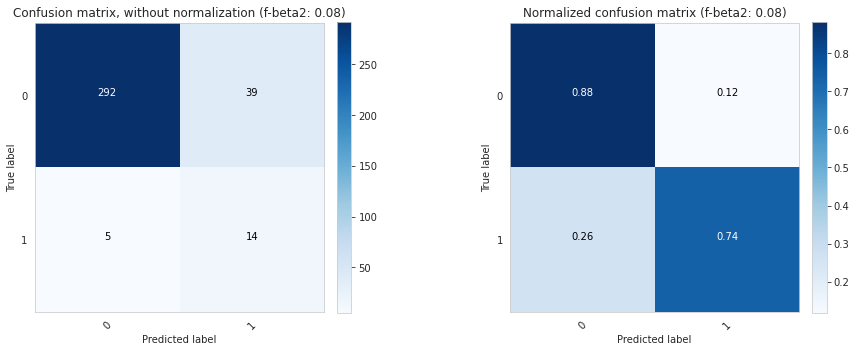



ROC Curve:


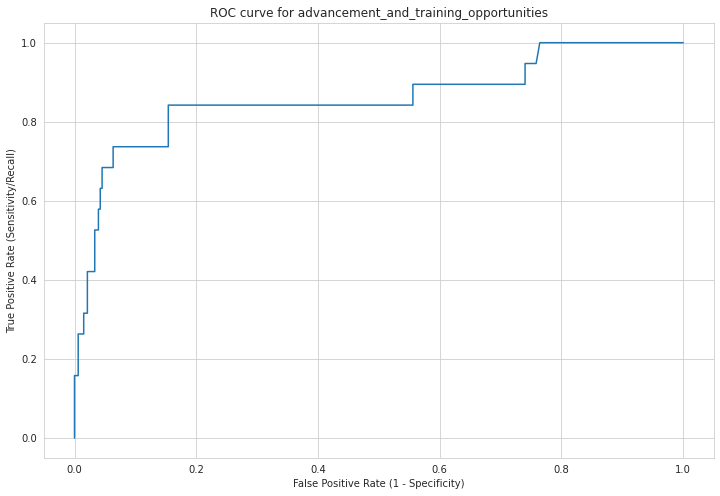

Predicted Probability Distribution:


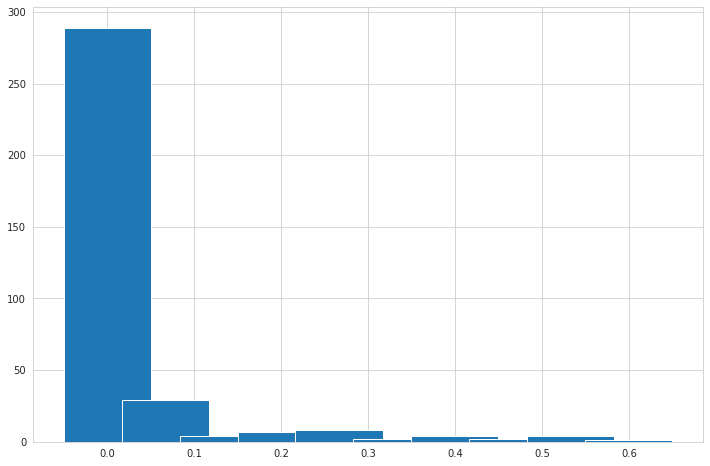



----------------------------------------------------------------------------------------------------


APPROPRIATE_STRESS_WORK_ASSIGNED_EQUITABLY

Null Accuracy:	0.9142857142857143
AUC Score:	0.8836458333333332

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9085714285714286	0.88	0.7828571428571428	
Cohen's Kappa:	0.41666666666666663	0.41200000000000003	0.33632734530938113	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.95                0.95                0.95                320                 
1                   0.4667              0.4667              0.4667              30                  
avg/total           0.7083              0.7083              0.7083              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9633              0.9031              0

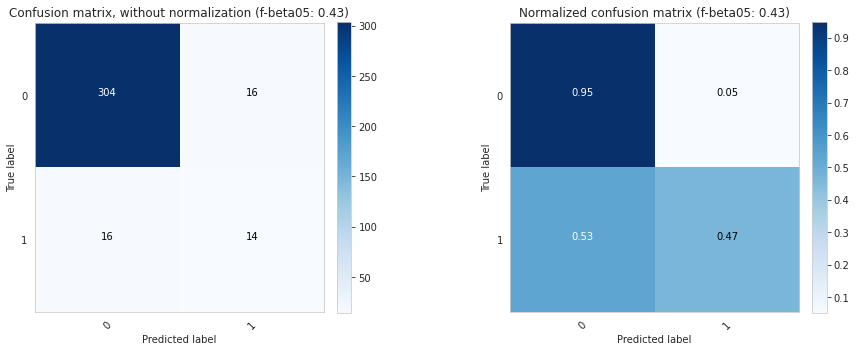

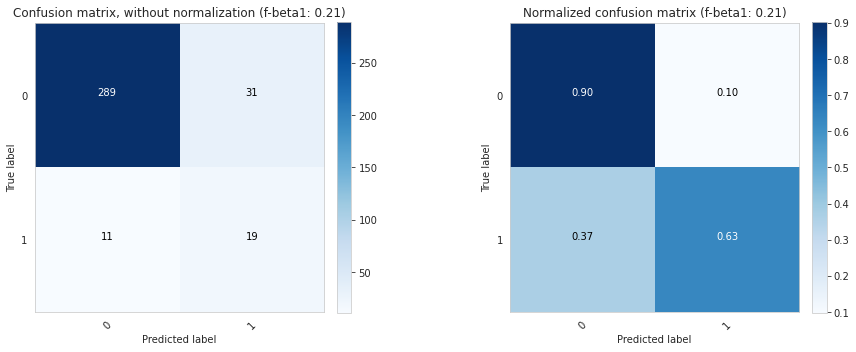

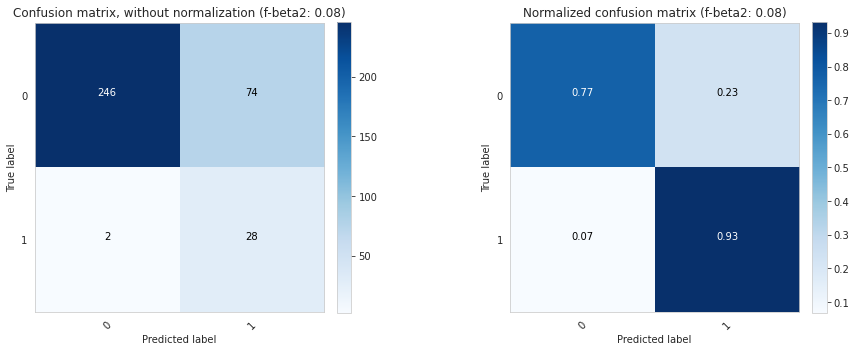



ROC Curve:


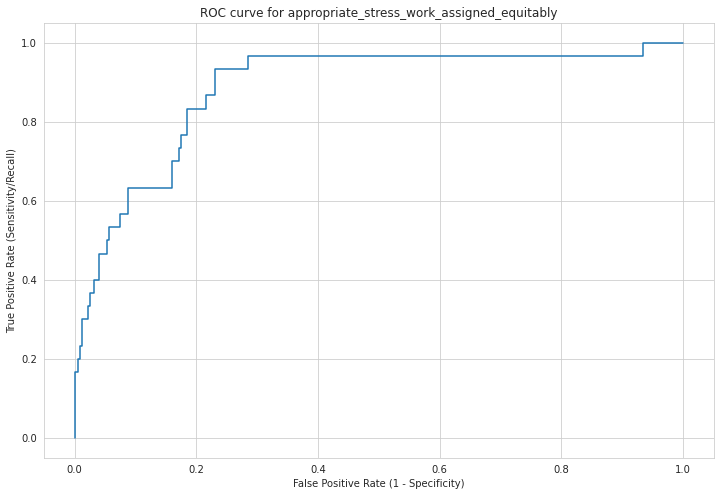

Predicted Probability Distribution:


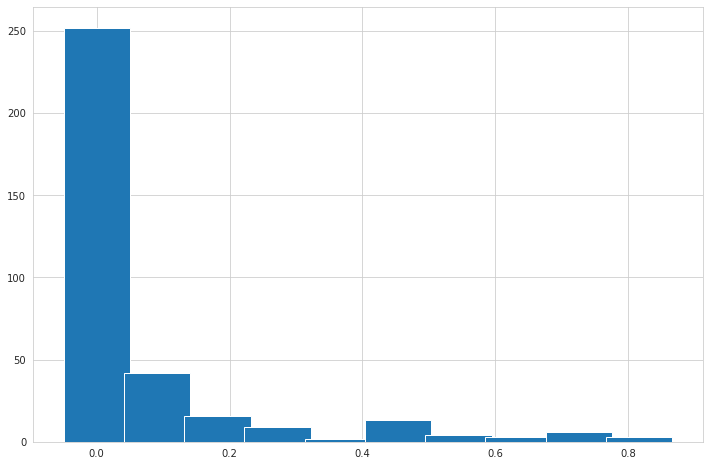



----------------------------------------------------------------------------------------------------


BENEFITS

Null Accuracy:	0.9742857142857143
AUC Score:	0.9602476376669925

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9771428571428571	0.9628571428571429	0.9428571428571428	
Cohen's Kappa:	0.5438253502769632	0.4165170556552963	0.388646288209607	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9883              0.9883              0.9883              341                 
1                   0.5556              0.5556              0.5556              9                   
avg/total           0.7719              0.7719              0.7719              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9881              0.9736              0.9808              341  

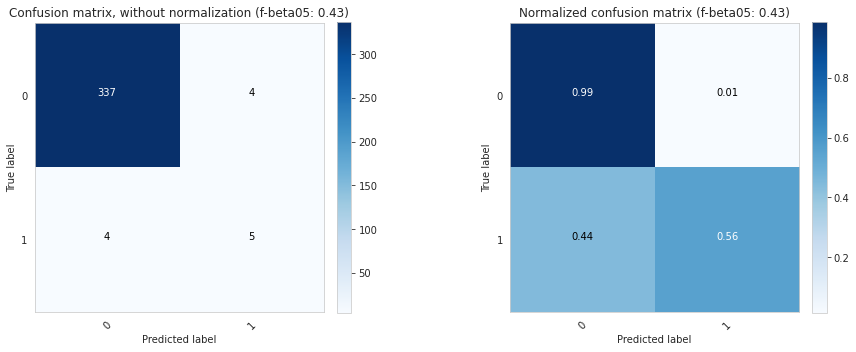

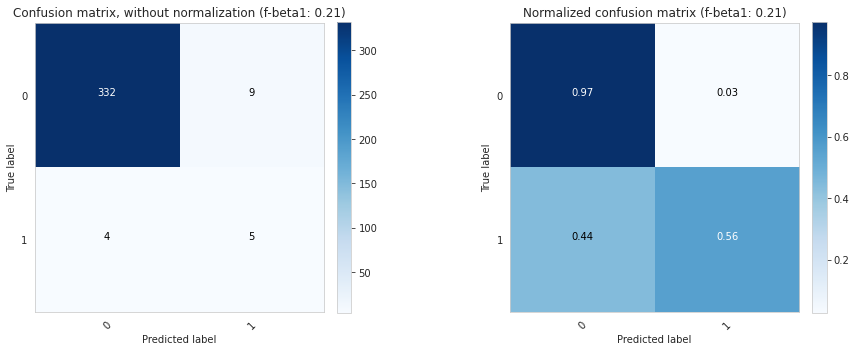

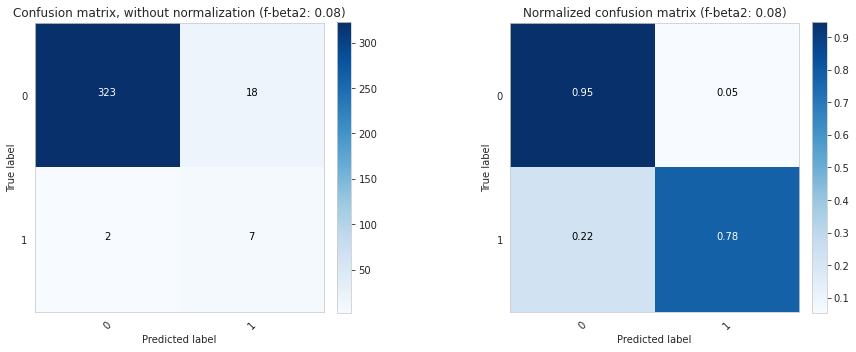



ROC Curve:


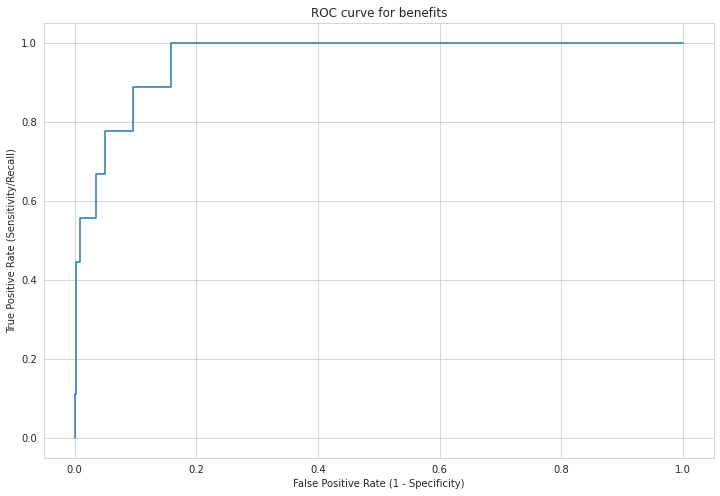

Predicted Probability Distribution:


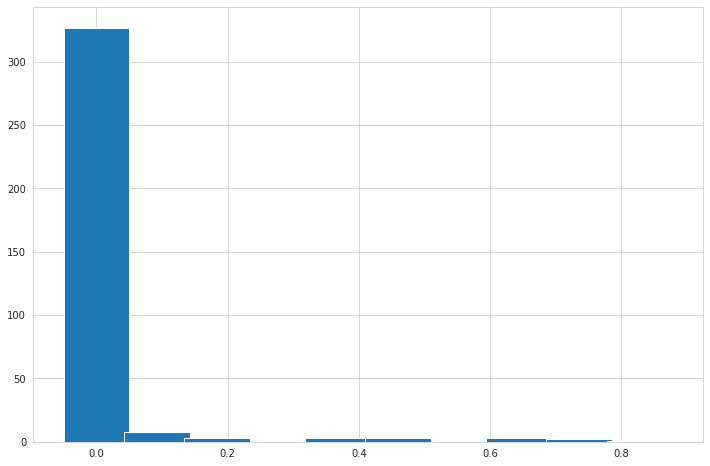



----------------------------------------------------------------------------------------------------


BETTER_WAYS_RECOGNIZED_PARTICIPATE_IN_DECISIONS

Null Accuracy:	0.9428571428571428
AUC Score:	0.9037121212121212

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9371428571428572	0.9028571428571428	0.8714285714285714	
Cohen's Kappa:	0.32098765432098764	0.26993865030674846	0.36157276043777864	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9583              0.9758              0.967               330                 
1                   0.4286              0.3                 0.3529              20                  
avg/total           0.6935              0.6379              0.66                350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9625              0.

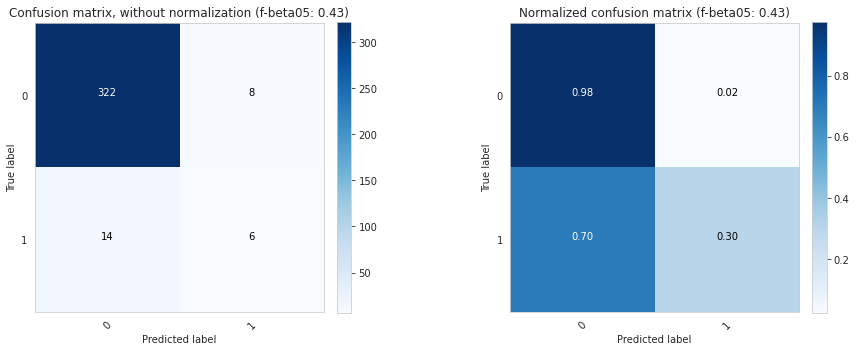

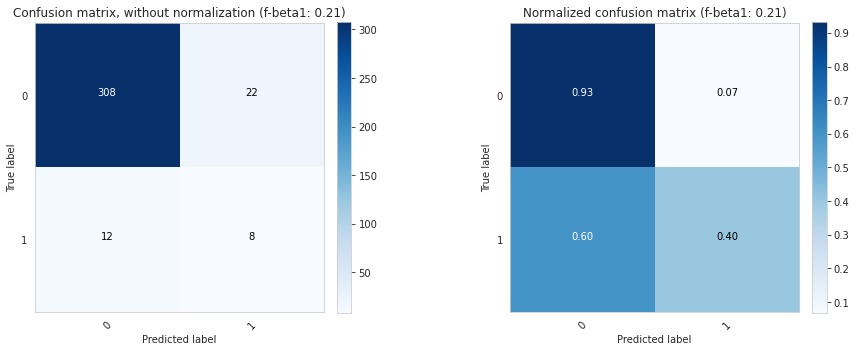

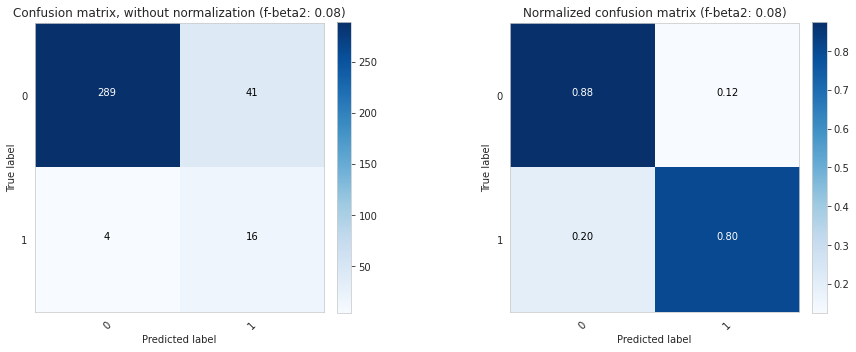



ROC Curve:


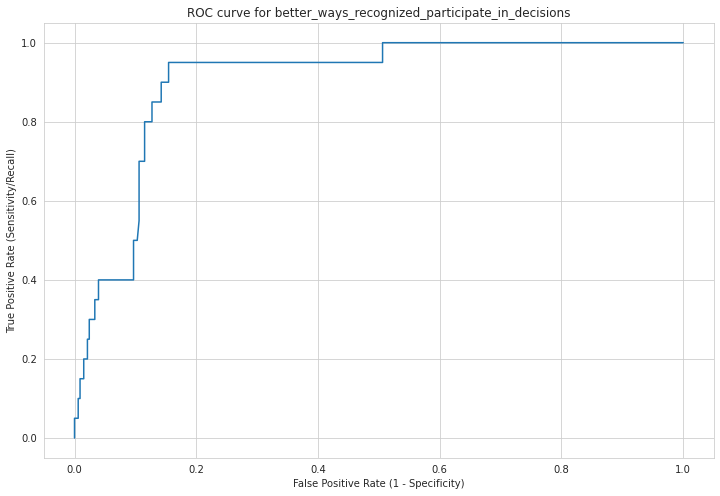

Predicted Probability Distribution:


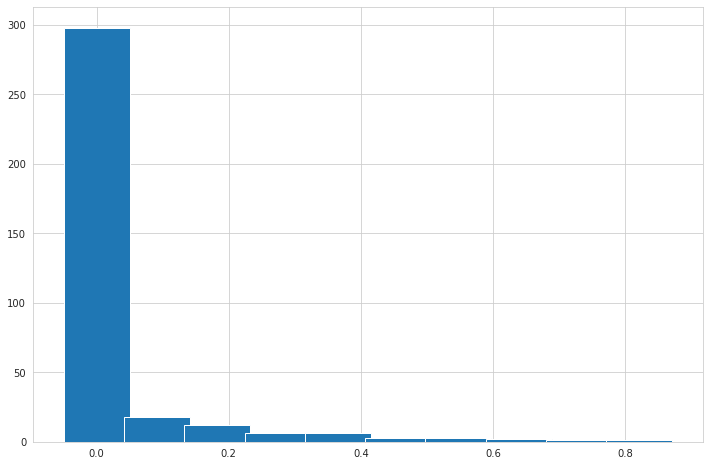



----------------------------------------------------------------------------------------------------


CAREER_ADVANCEMENT

Null Accuracy:	0.9257142857142857
AUC Score:	0.8612891737891738

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9228571428571428	0.8857142857142857	0.7885714285714286	
Cohen's Kappa:	0.30361090641120114	0.3523316062176166	0.24118129614438077	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9433              0.9753              0.959               324                 
1                   0.4667              0.2692              0.3415              26                  
avg/total           0.705               0.6223              0.6502              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.961               0.9136              0.9367      

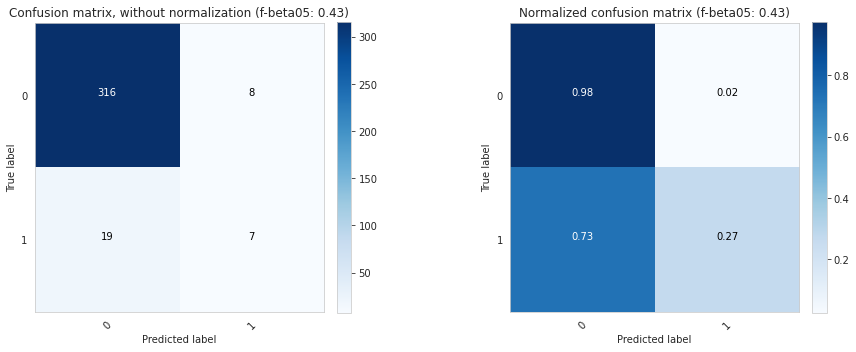

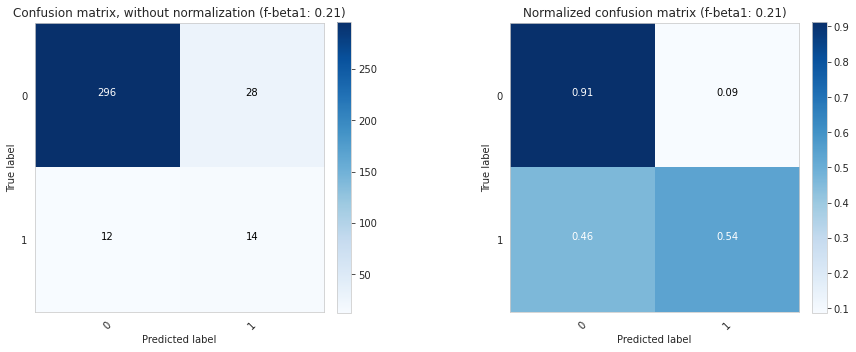

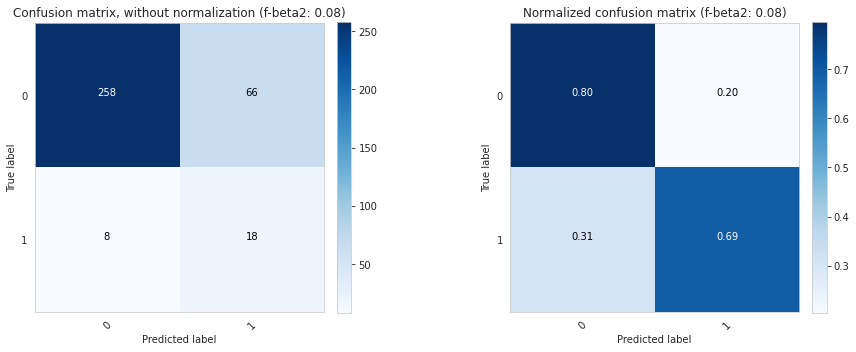



ROC Curve:


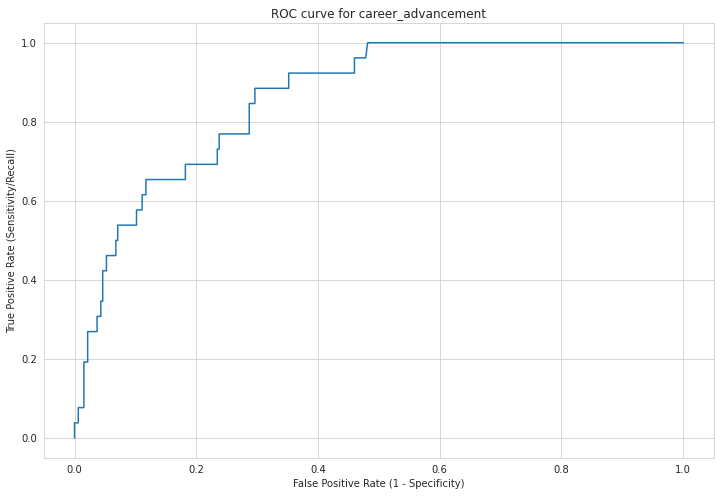

Predicted Probability Distribution:


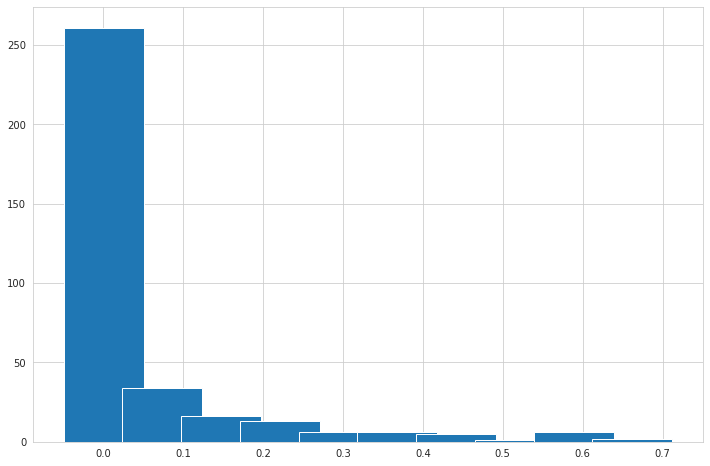



----------------------------------------------------------------------------------------------------


COMMITTED_TO_DIVERSITY

Null Accuracy:	0.9342857142857143
AUC Score:	0.8986172051588884

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9457142857142857	0.9	0.8542857142857143	
Cohen's Kappa:	0.4596131968145619	0.41156691324815065	0.3650850110265348	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9583              0.9847              0.9713              327                 
1                   0.6429              0.3913              0.4865              23                  
avg/total           0.8006              0.688               0.7289              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.974               0.9174              0.9449              327 

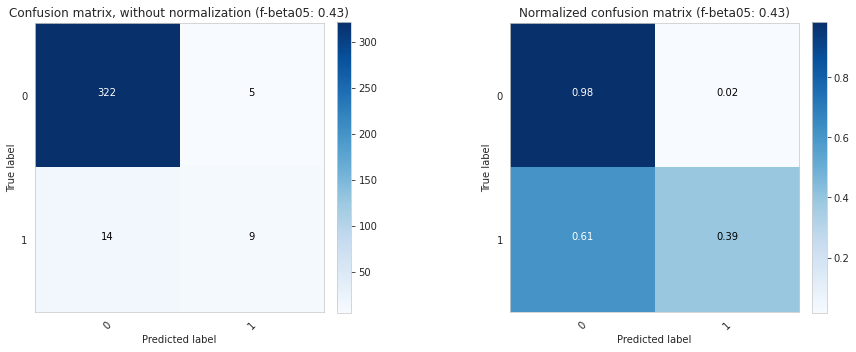

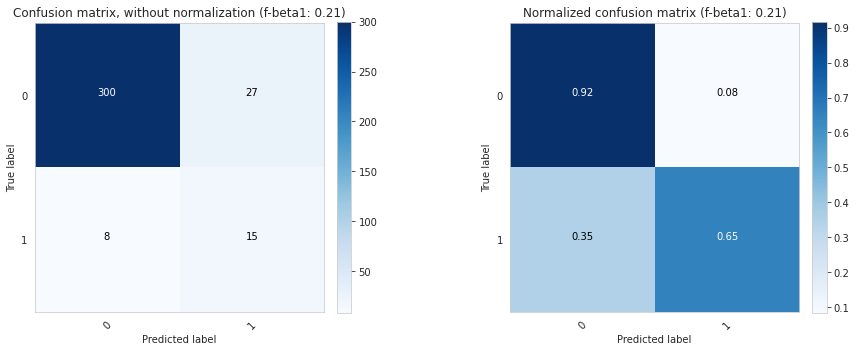

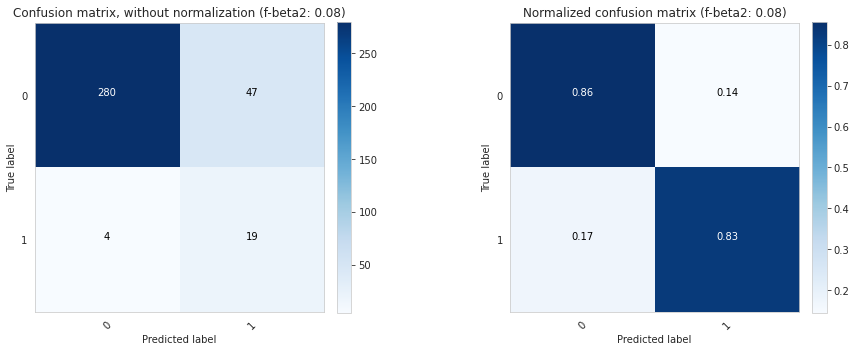



ROC Curve:


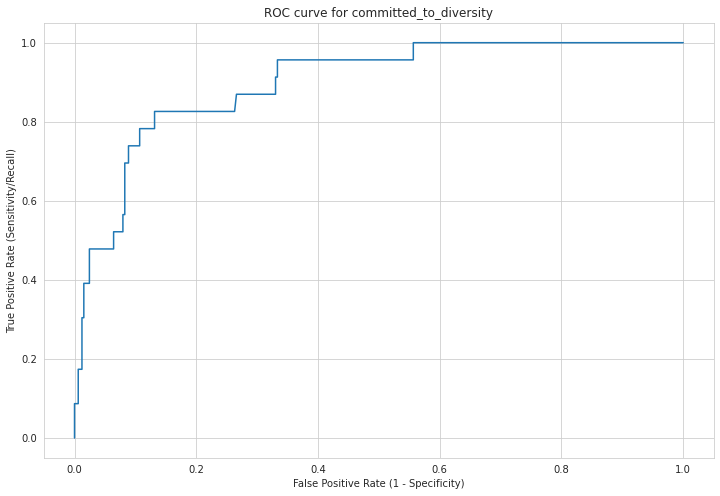

Predicted Probability Distribution:


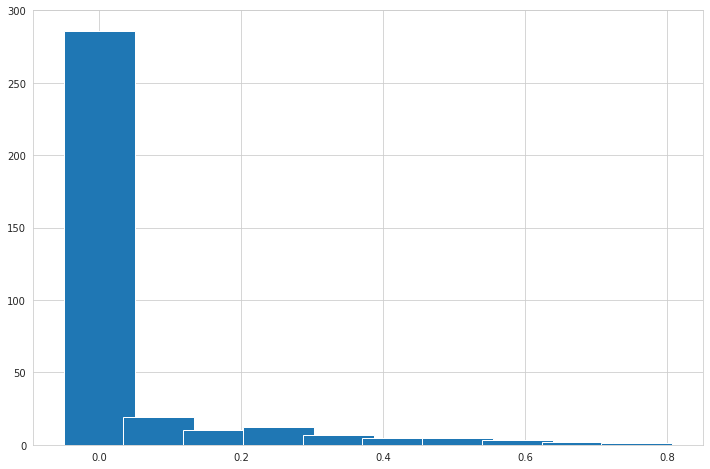



----------------------------------------------------------------------------------------------------


COMMUNICATES_ESSENTIAL_INFORMATION

Null Accuracy:	0.9571428571428572
AUC Score:	0.9498507462686567

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9742857142857143	0.9685714285714285	0.94	
Cohen's Kappa:	0.6962391513982642	0.6695278969957081	0.5255003227888961	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.988               0.9851              0.9865              335                 
1                   0.6875              0.7333              0.7097              15                  
avg/total           0.8378              0.8592              0.8481              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9909              0.9761              0.9835      

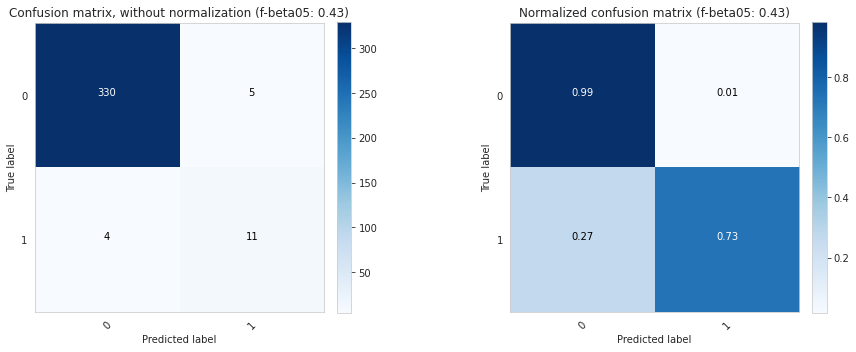

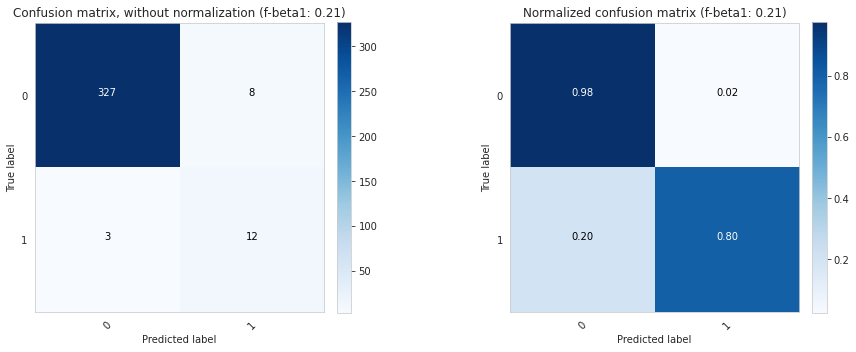

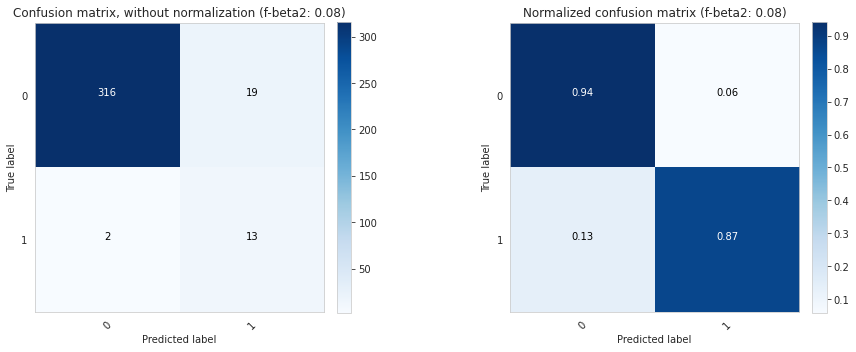



ROC Curve:


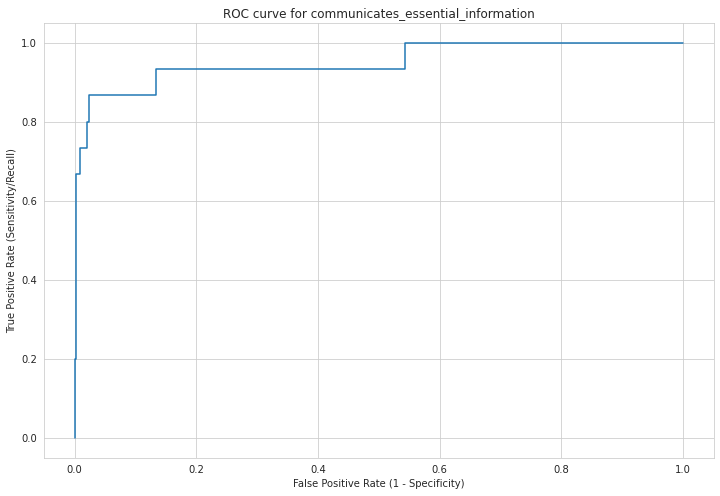

Predicted Probability Distribution:


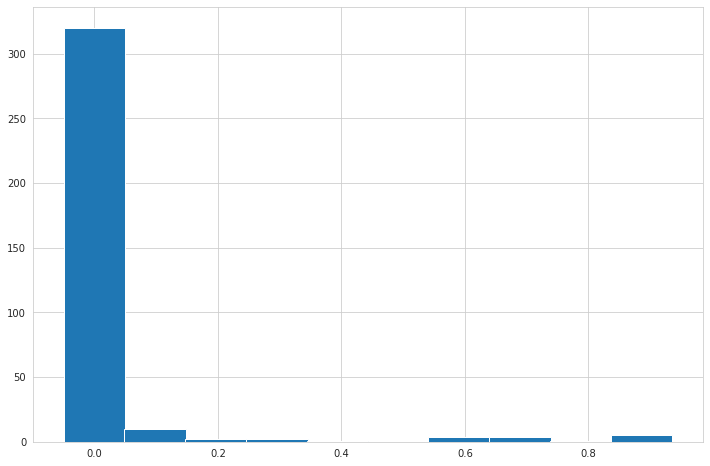



----------------------------------------------------------------------------------------------------


ETHICAL_CONDUCT_PERFORM_RESPONSIBILITIES_SPIRIT_OF_COOPERATION

Null Accuracy:	0.8428571428571429
AUC Score:	0.7819106317411402

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.8371428571428572	0.7742857142857142	0.6514285714285715	
Cohen's Kappa:	0.25919049387300397	0.28975083483174924	0.2435783879539415	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.8742              0.9424              0.907               295                 
1                   0.4688              0.2727              0.3448              55                  
avg/total           0.6715              0.6076              0.6259              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.903   

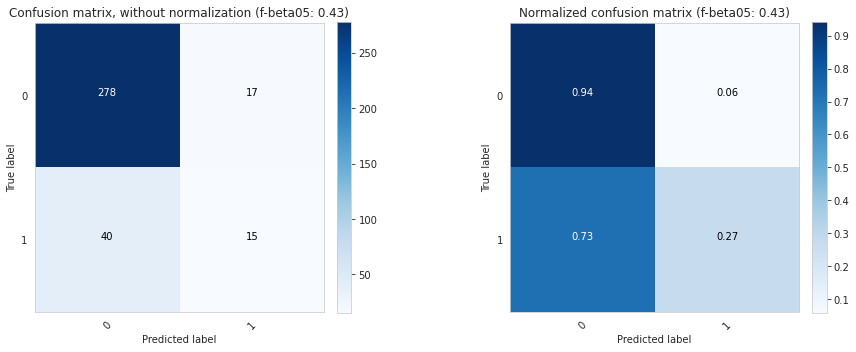

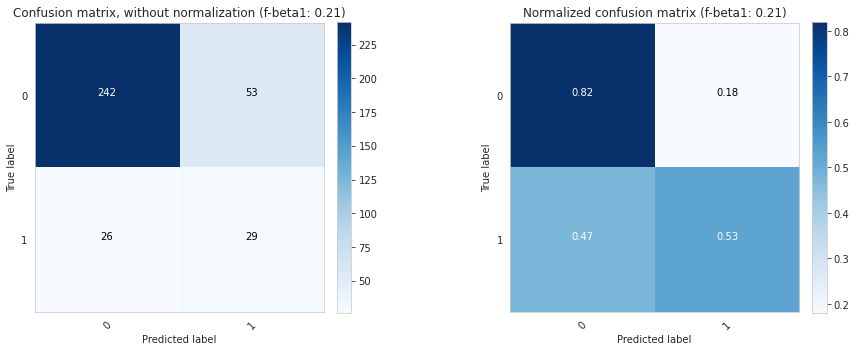

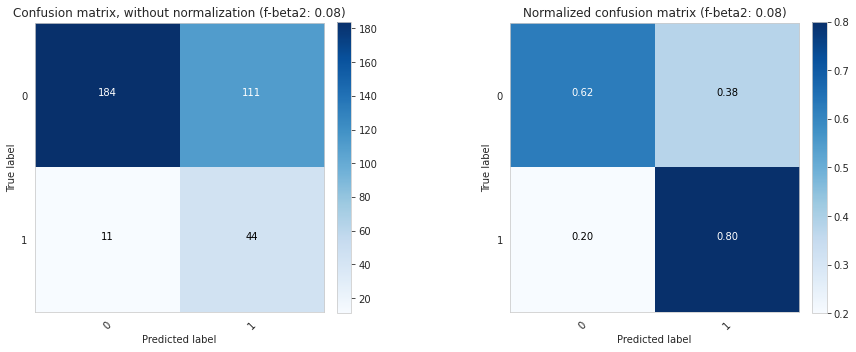



ROC Curve:


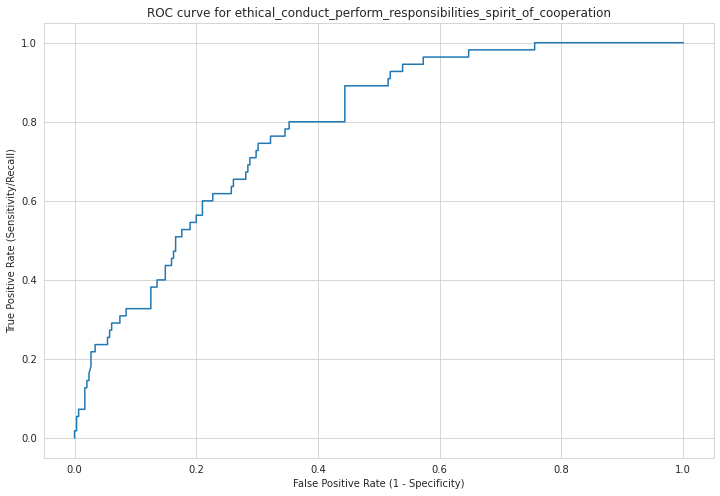

Predicted Probability Distribution:


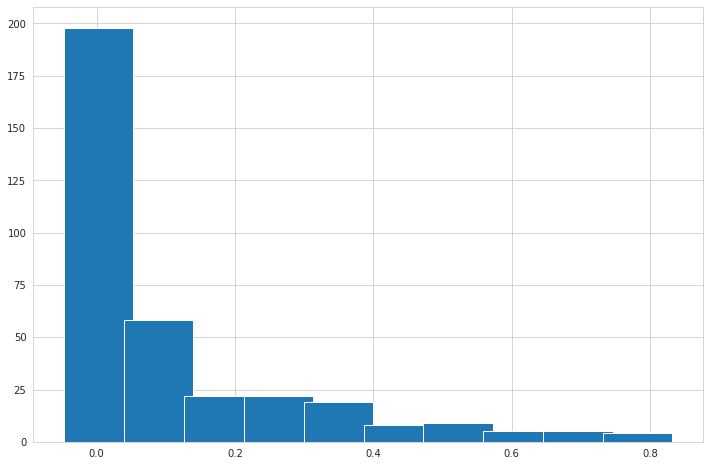



----------------------------------------------------------------------------------------------------


EVALUATED_FAIRLY

Null Accuracy:	0.9685714285714285
AUC Score:	0.9237060874229016

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9657142857142857	0.9571428571428572	0.9285714285714286	
Cohen's Kappa:	0.31662870159453294	0.4229500989228402	0.3286788399570355	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9767              0.9882              0.9824              339                 
1                   0.4286              0.2727              0.3333              11                  
avg/total           0.7026              0.6305              0.6579              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.985               0.9705              0.9777         

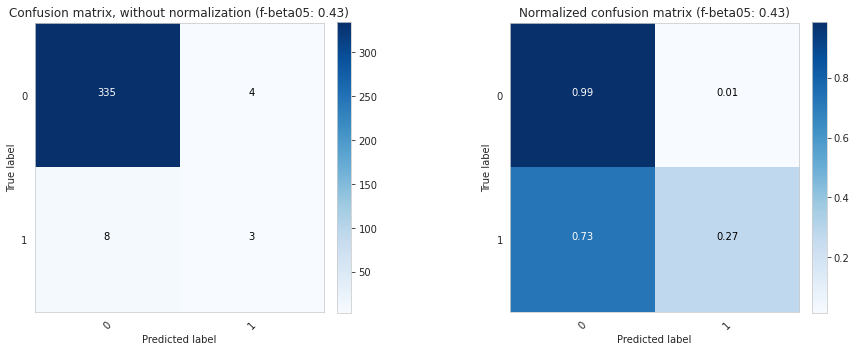

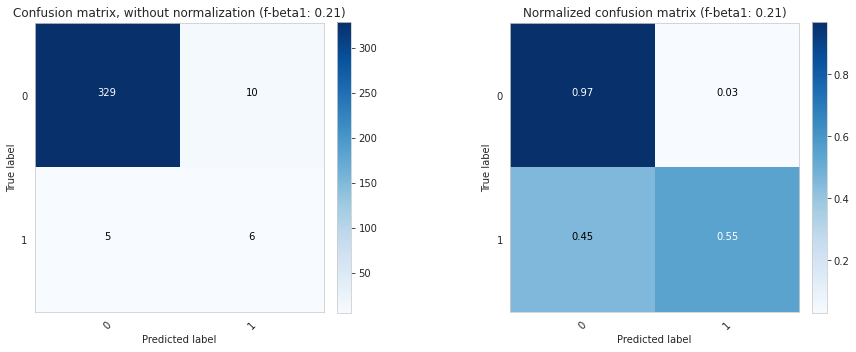

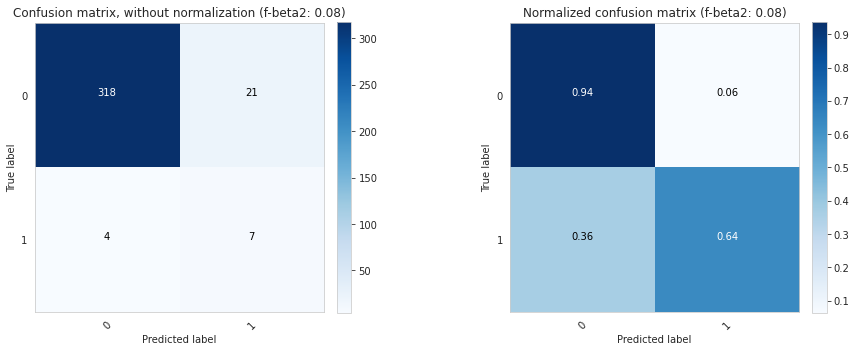



ROC Curve:


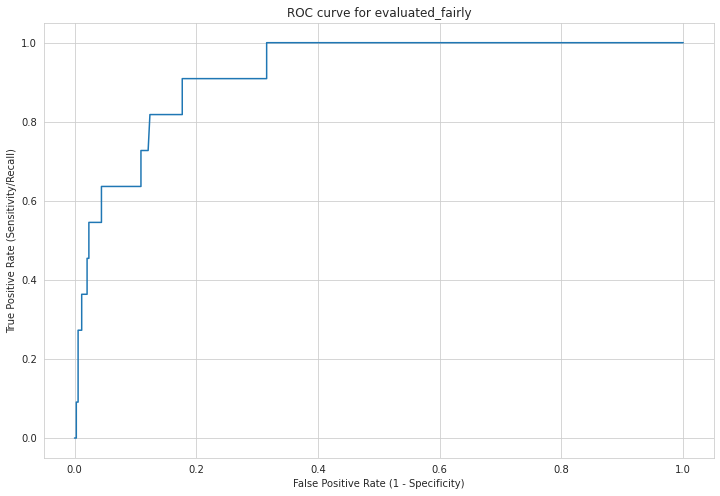

Predicted Probability Distribution:


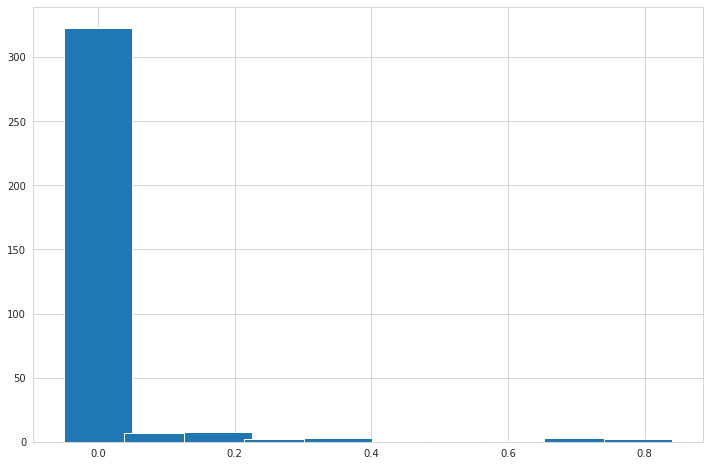



----------------------------------------------------------------------------------------------------


EXPERIENCED_DISCRIMINATION

Null Accuracy:	0.9171428571428571
AUC Score:	0.9264152970243851

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9371428571428572	0.9114285714285715	0.84	
Cohen's Kappa:	0.5270851246775581	0.5159275452841974	0.3993993993993995	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9544              0.9782              0.9662              321                 
1                   0.6667              0.4828              0.56                29                  
avg/total           0.8105              0.7305              0.7631              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9708              0.9315              0.9507              

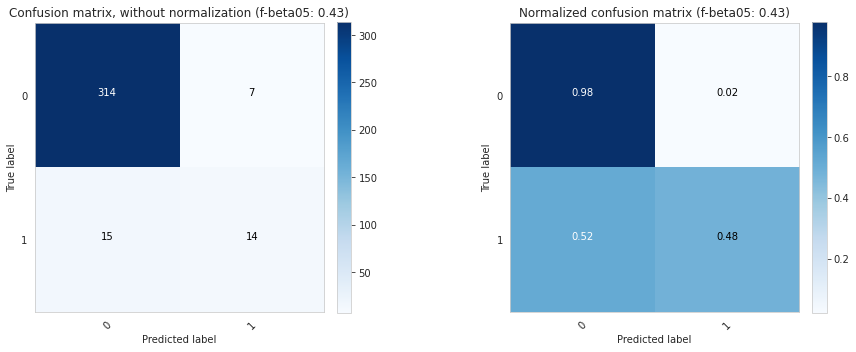

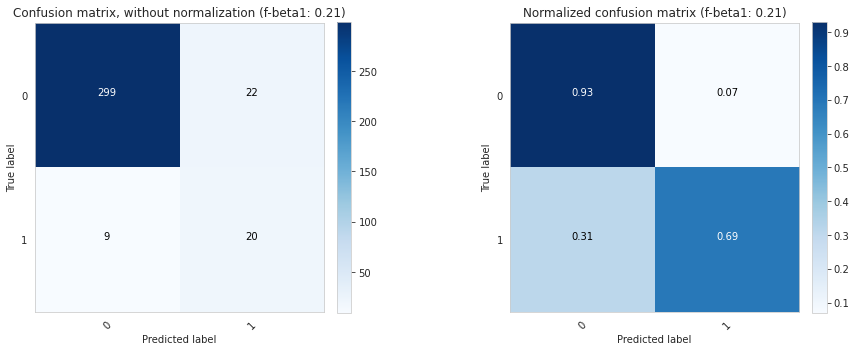

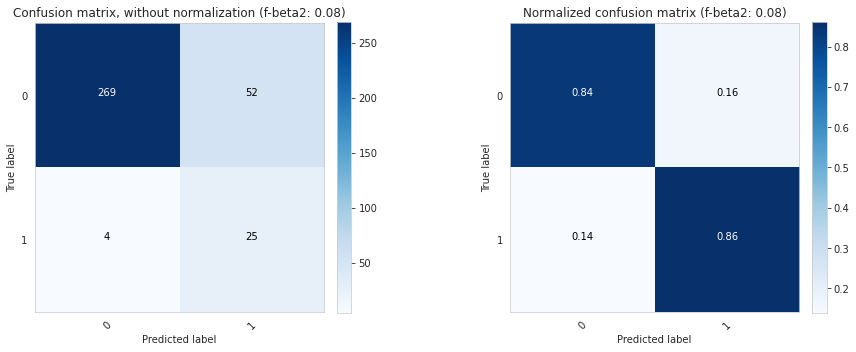



ROC Curve:


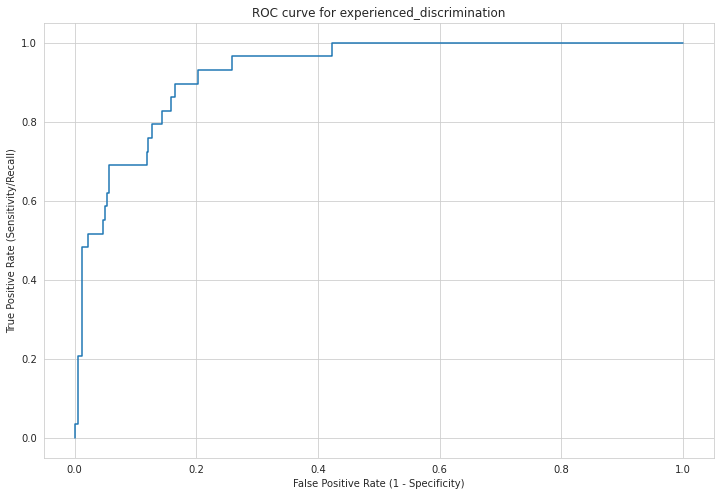

Predicted Probability Distribution:


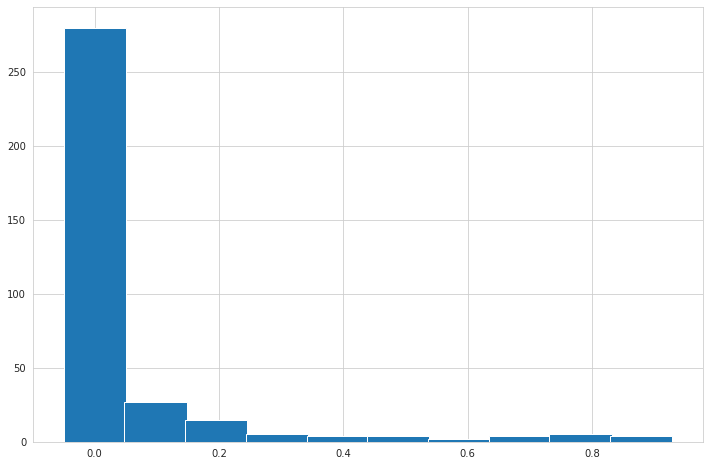



----------------------------------------------------------------------------------------------------


FACILITIES_WORKSPACE_SAFETY

Null Accuracy:	0.9571428571428572
AUC Score:	0.940497512437811

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9685714285714285	0.9571428571428572	0.9257142857142857	
Cohen's Kappa:	0.5764576457645765	0.5231607629427792	0.44680851063829785	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9793              0.9881              0.9837              335                 
1                   0.6667              0.5333              0.5926              15                  
avg/total           0.823               0.7607              0.7881              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9819              0.9731              0.977

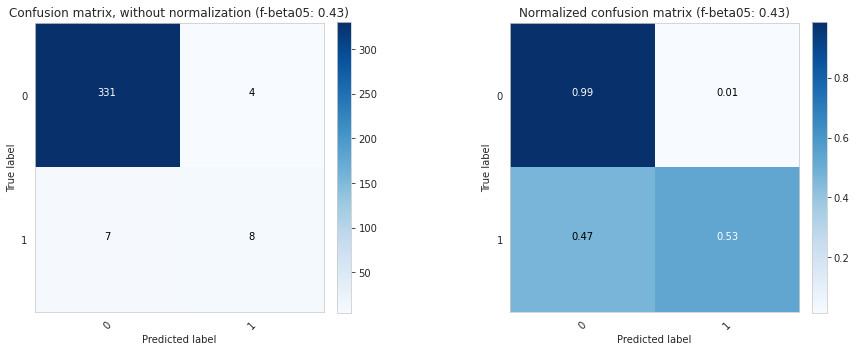

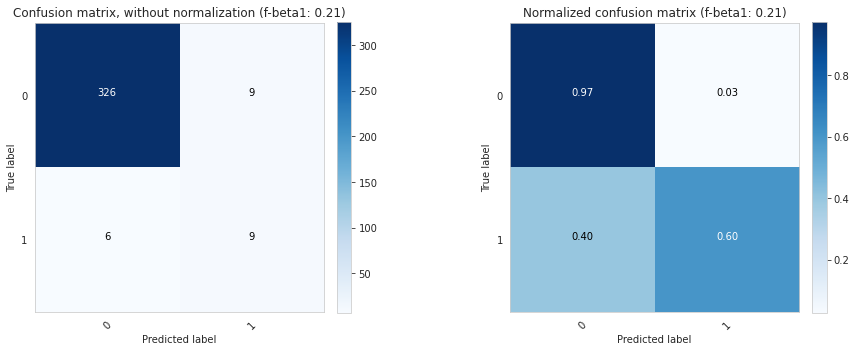

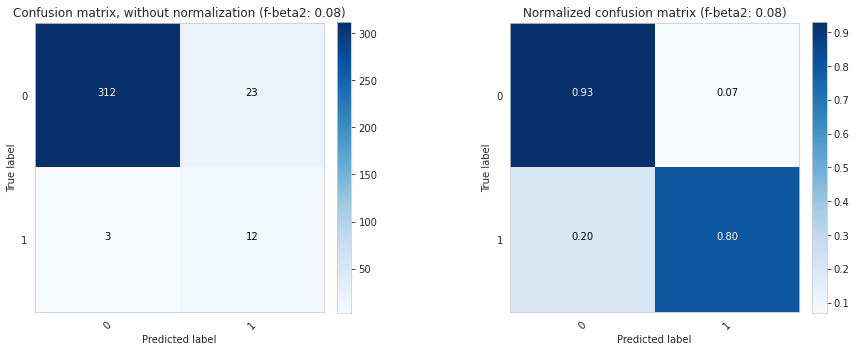



ROC Curve:


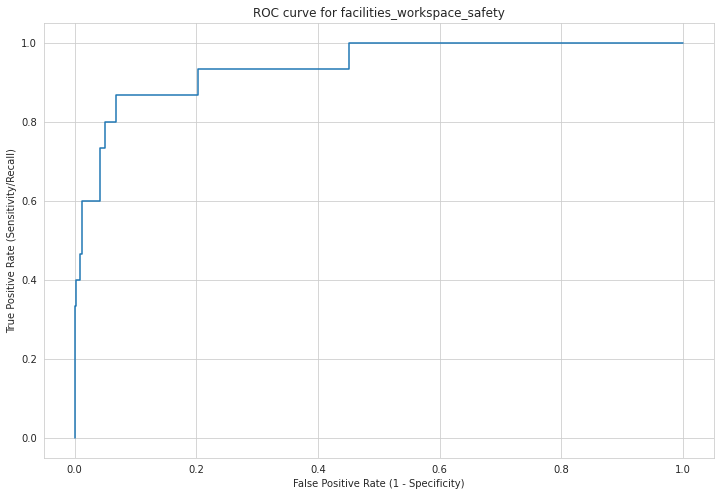

Predicted Probability Distribution:


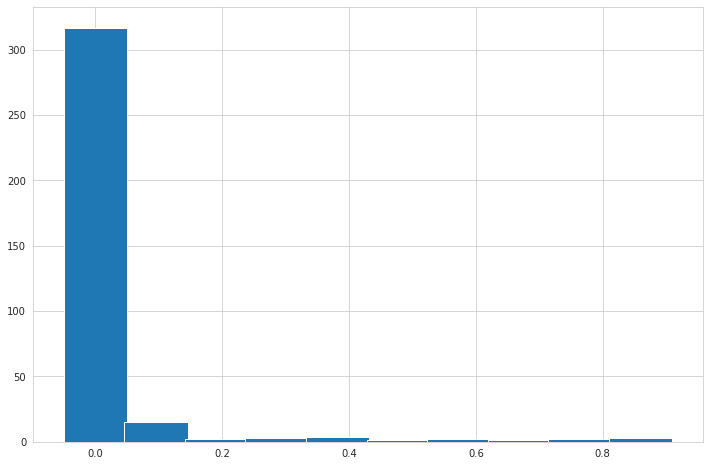



----------------------------------------------------------------------------------------------------


FACULTY_VALUE_CONTRIBUTIONS

Null Accuracy:	0.8828571428571429
AUC Score:	0.8628936774804641

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.8571428571428571	0.8514285714285714	0.76	
Cohen's Kappa:	0.20893228460356195	0.4173016584491259	0.3567584124622588	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9034              0.9385              0.9206              309                 
1                   0.3448              0.2439              0.2857              41                  
avg/total           0.6241              0.5912              0.6032              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9477              0.8803              0.9128            

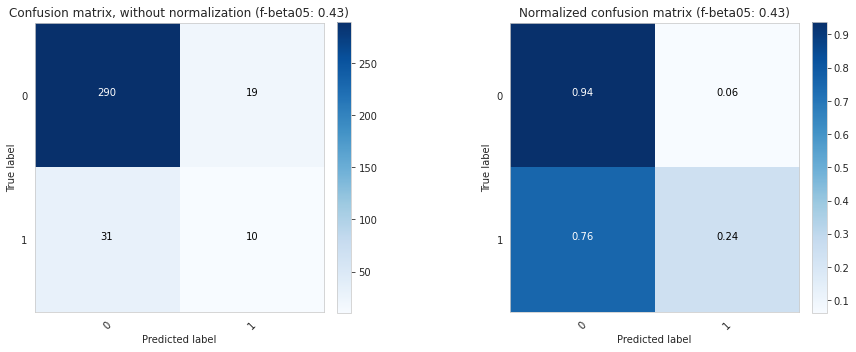

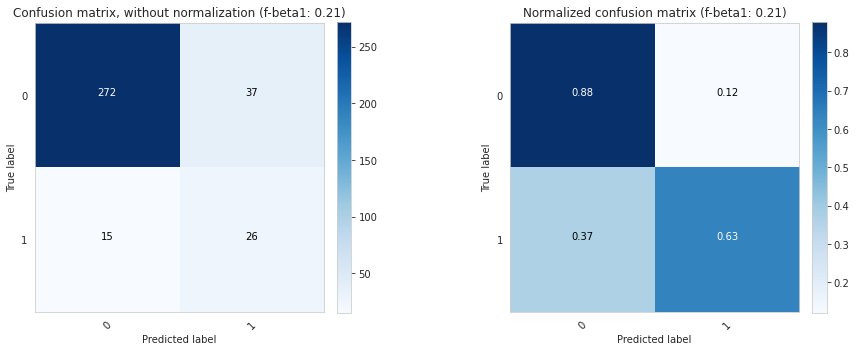

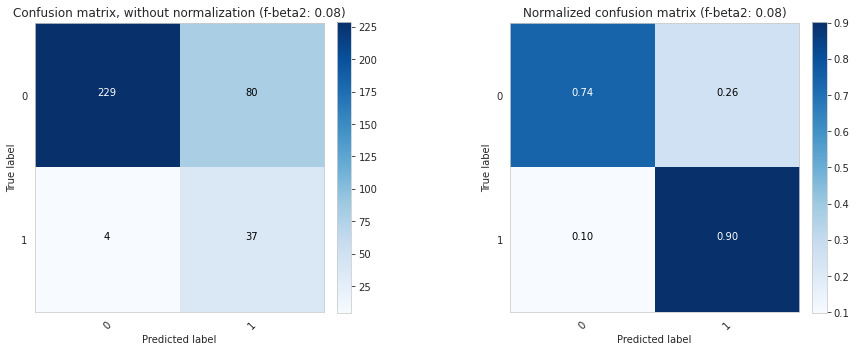



ROC Curve:


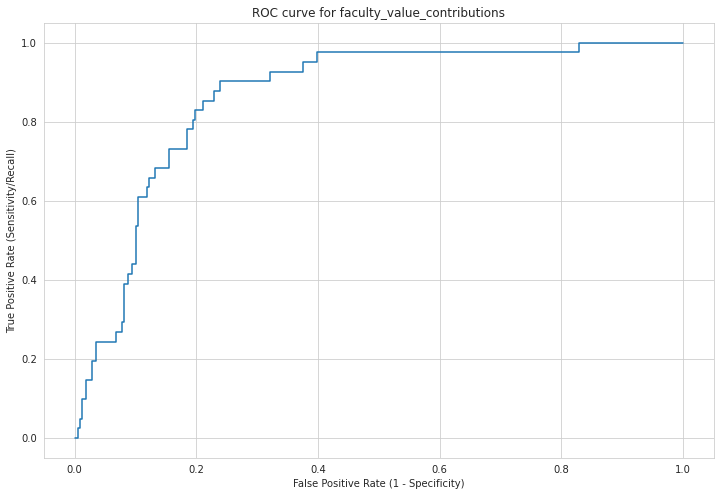

Predicted Probability Distribution:


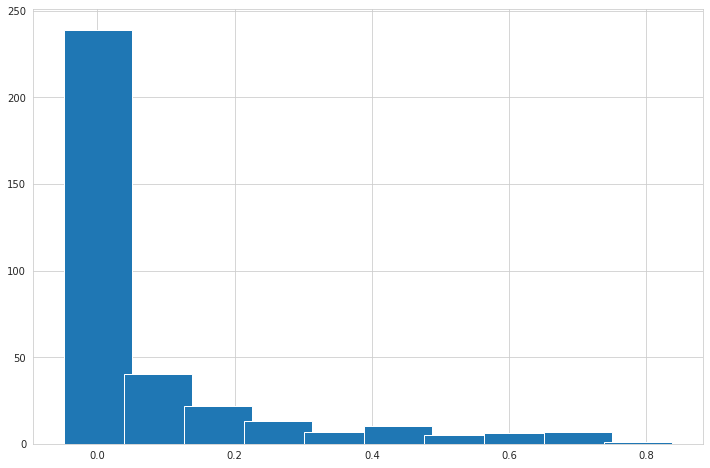



----------------------------------------------------------------------------------------------------


FAVORITISM_CLIQUES

Null Accuracy:	0.9714285714285714
AUC Score:	0.9255882352941176

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9628571428571429	0.9571428571428572	0.9285714285714286	
Cohen's Kappa:	0.2967542503863987	0.3260590500641848	0.3305279265493496	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9795              0.9824              0.9809              340                 
1                   0.3333              0.3                 0.3158              10                  
avg/total           0.6564              0.6412              0.6483              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9822              0.9735              0.9778        

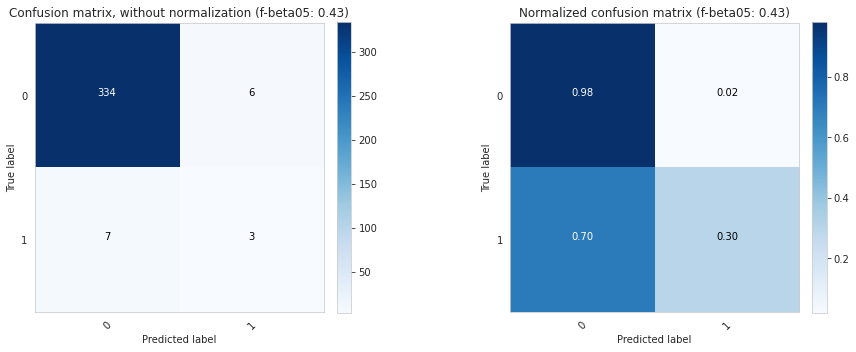

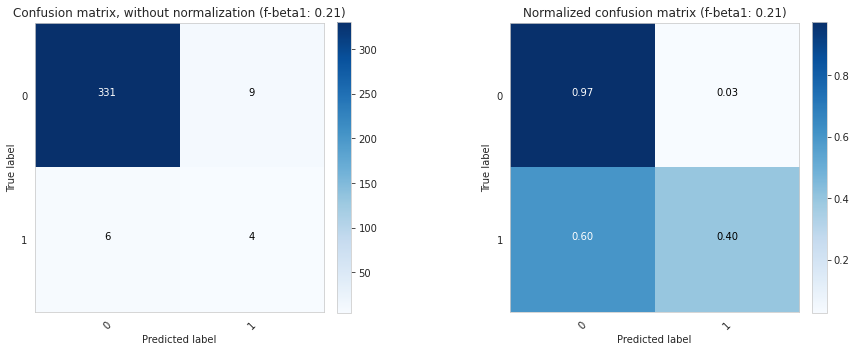

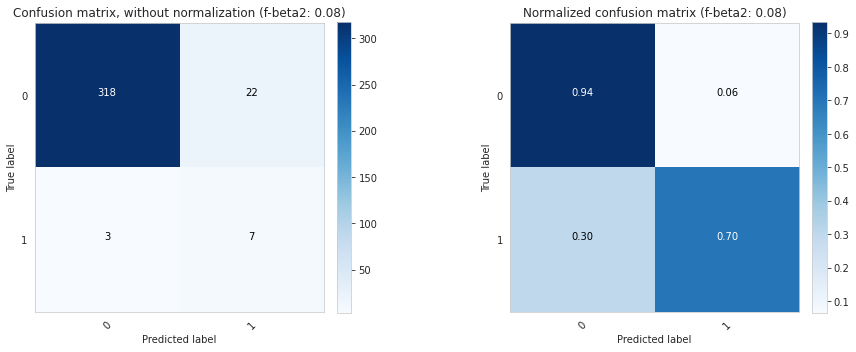



ROC Curve:


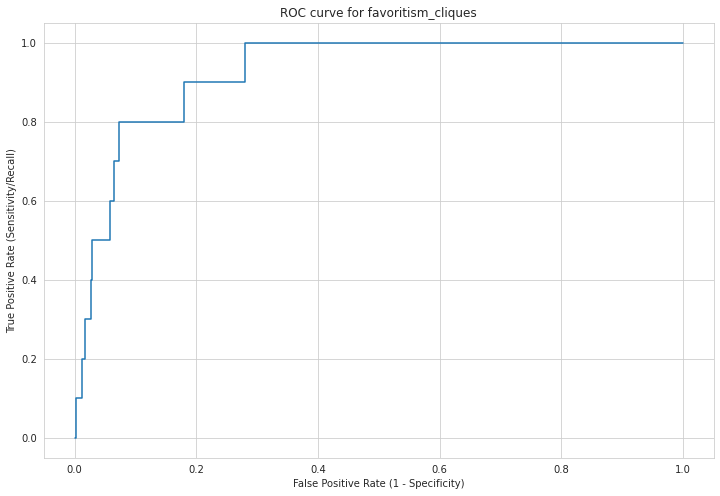

Predicted Probability Distribution:


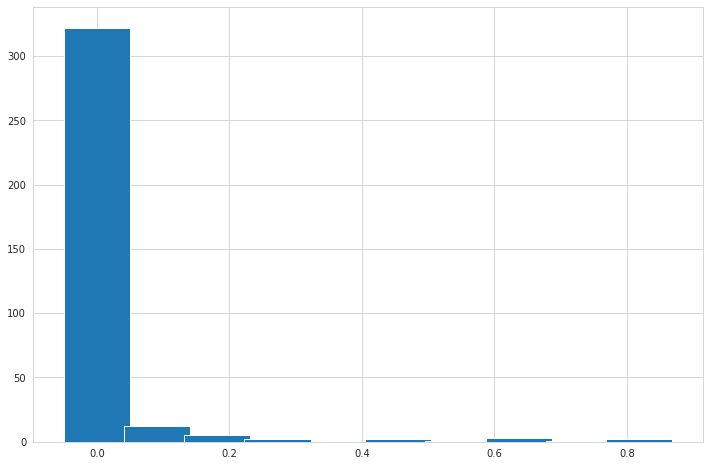



----------------------------------------------------------------------------------------------------


FEAR_OF_RETALIATION_NEGATIVE_CONSEQUENCES

Null Accuracy:	0.8771428571428571
AUC Score:	0.903113400499962

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.8714285714285714	0.8342857142857143	0.7914285714285715	
Cohen's Kappa:	0.45270692890402386	0.46604240096796257	0.42050351553640275	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9396              0.9121              0.9256              307                 
1                   0.4808              0.5814              0.5263              43                  
avg/total           0.7102              0.7467              0.726               350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9734              0.8339   

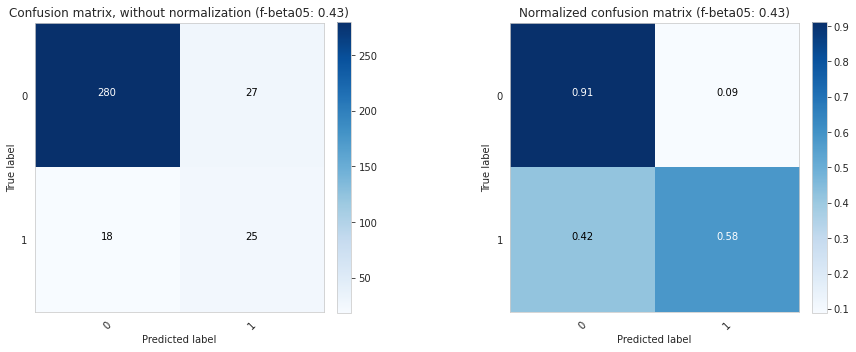

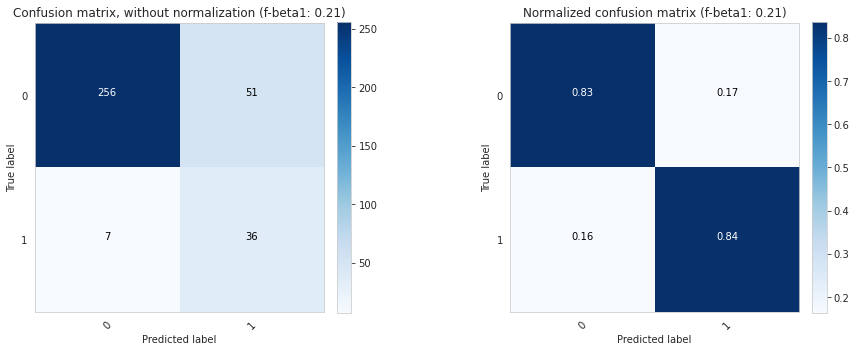

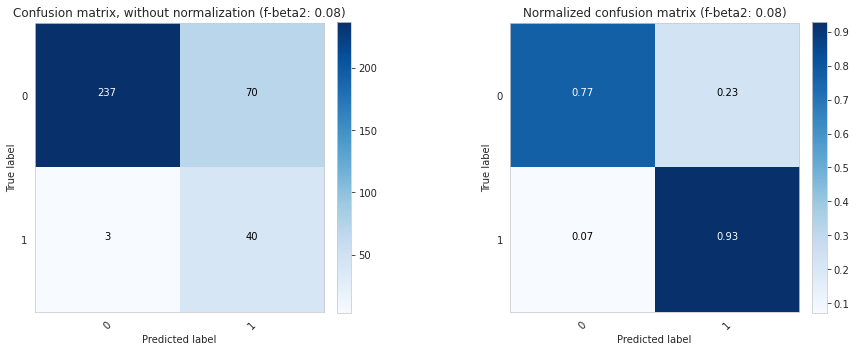



ROC Curve:


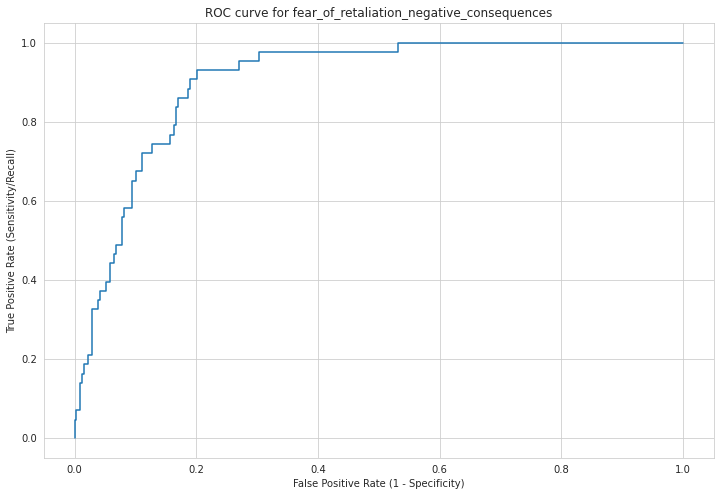

Predicted Probability Distribution:


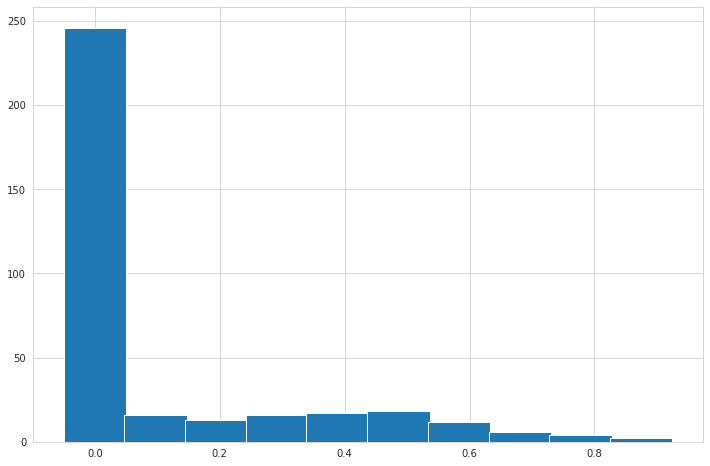



----------------------------------------------------------------------------------------------------


FEEL_VALUED_BY_DEPARTMENT

Null Accuracy:	0.8914285714285715
AUC Score:	0.7945344129554657

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.8857142857142857	0.8285714285714286	0.6942857142857143	
Cohen's Kappa:	0.2956329241296035	0.28062482872019723	0.1842025007624275	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9172              0.9583              0.9373              312                 
1                   0.4583              0.2895              0.3548              38                  
avg/total           0.6878              0.6239              0.6461              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9315              0.8718              0.9007

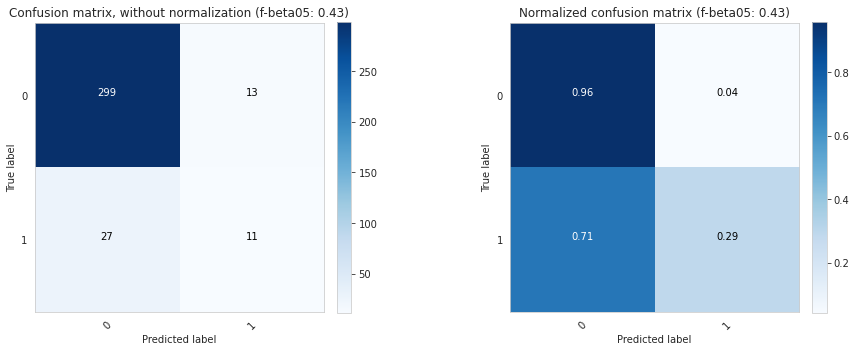

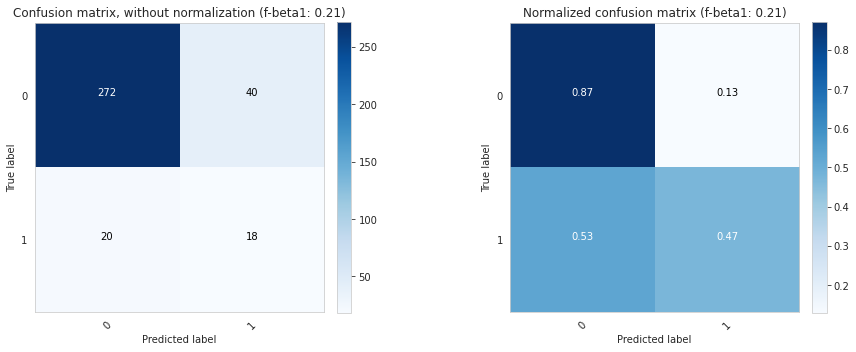

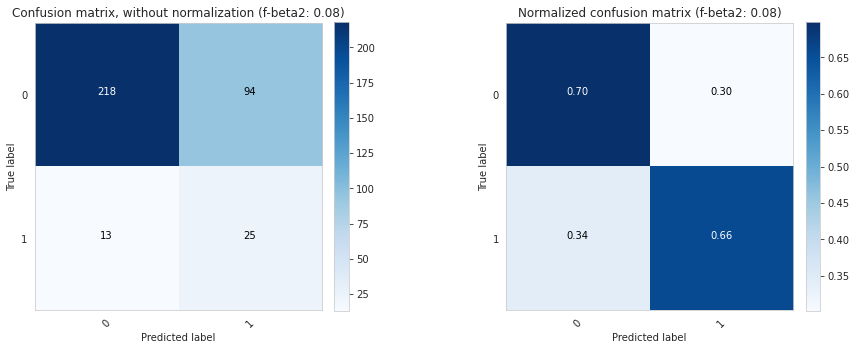



ROC Curve:


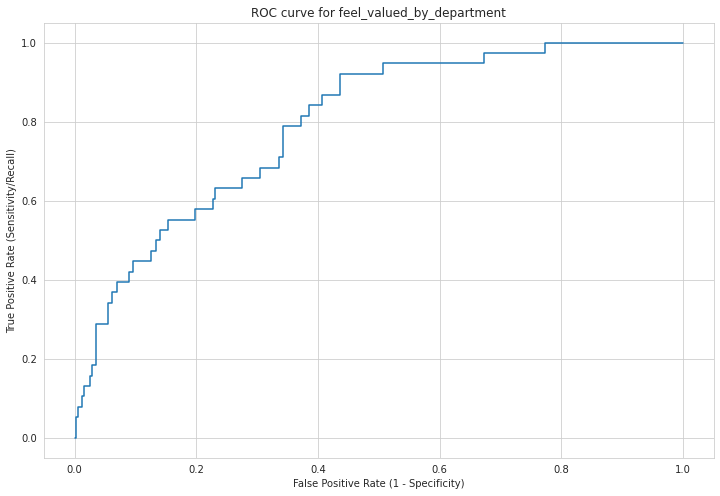

Predicted Probability Distribution:


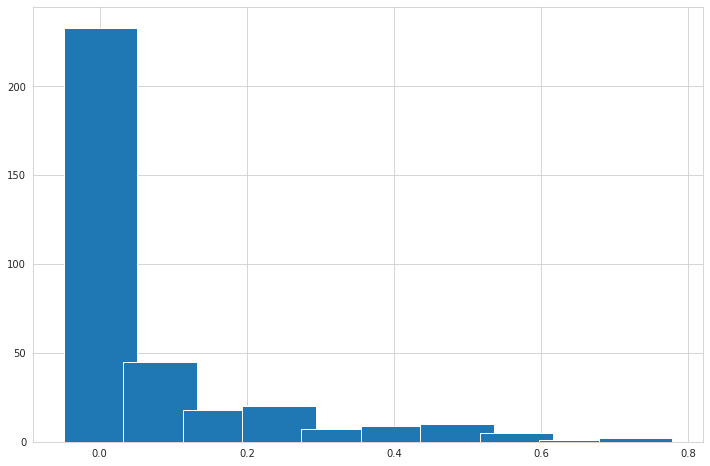



----------------------------------------------------------------------------------------------------


FLEXIBILITY_WORK_LIFE_BALANCE

Null Accuracy:	0.9628571428571429
AUC Score:	0.9577721981282812

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9742857142857143	0.9628571428571429	0.9457142857142857	
Cohen's Kappa:	0.5149368647982753	0.49922958397534667	0.48743641128410675	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9767              0.997               0.9868              337                 
1                   0.8333              0.3846              0.5263              13                  
avg/total           0.905               0.6908              0.7565              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9821              0.9792              0

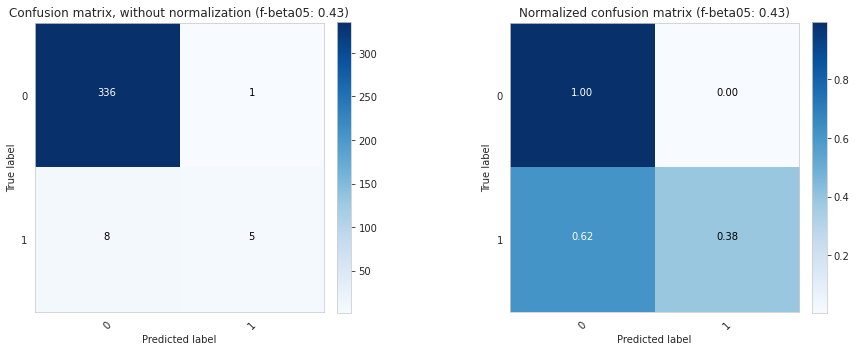

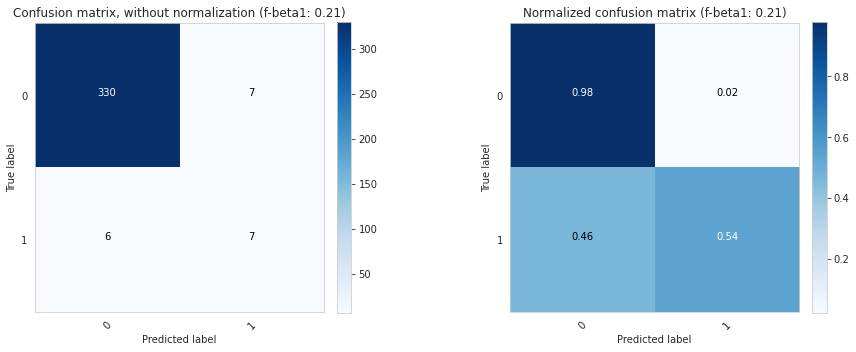

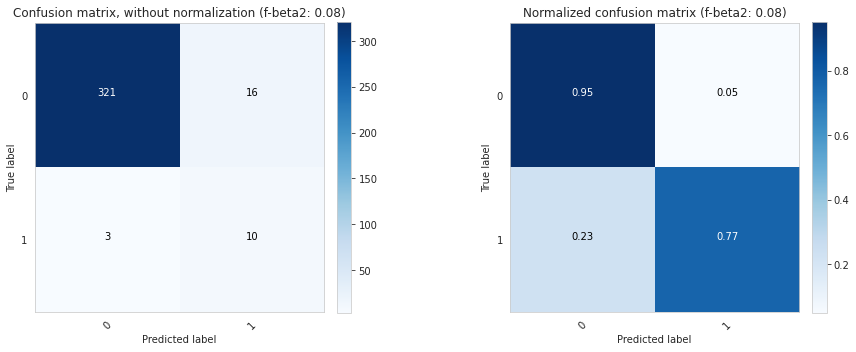



ROC Curve:


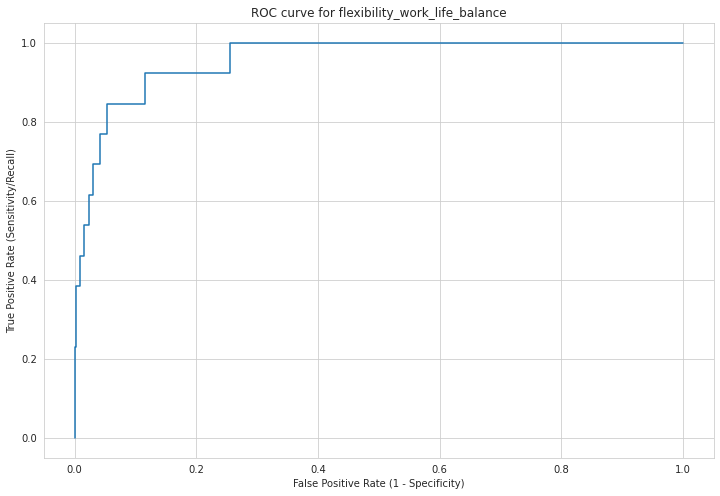

Predicted Probability Distribution:


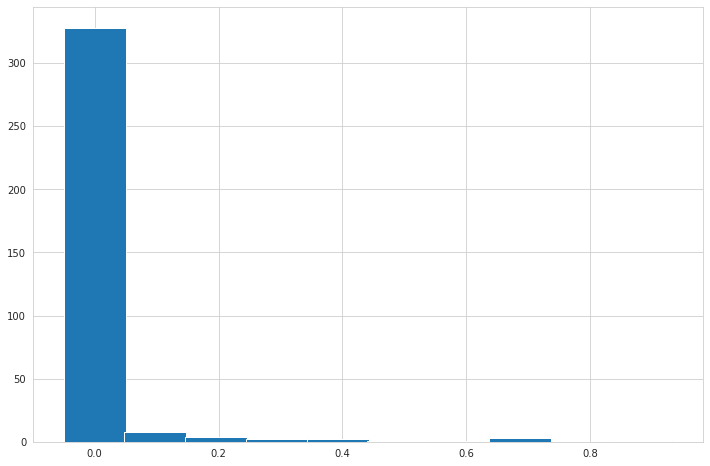



----------------------------------------------------------------------------------------------------


GOOD_USE_OF_SKILLS

Null Accuracy:	0.98
AUC Score:	0.7877967513536026

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9771428571428571	0.9657142857142857	0.9285714285714286	
Cohen's Kappa:	-0.005025125628140614	-0.016949152542372836	0.11095305832147928	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9799              0.9971              0.9884              343                 
1                   0.0                 0.0                 0.0                 7                   
avg/total           0.49                0.4985              0.4942              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9797              0.9854              0.9826              3

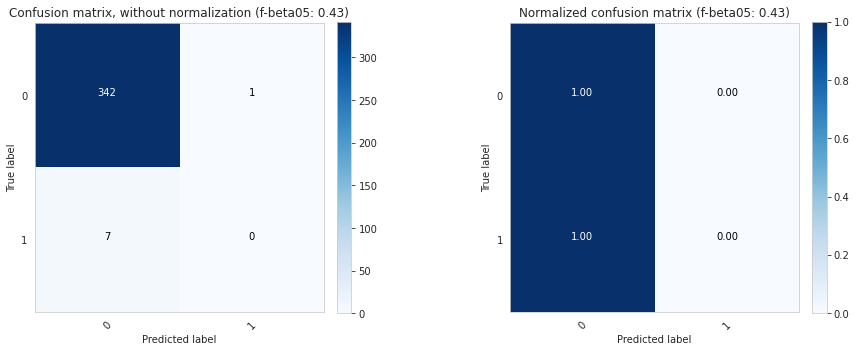

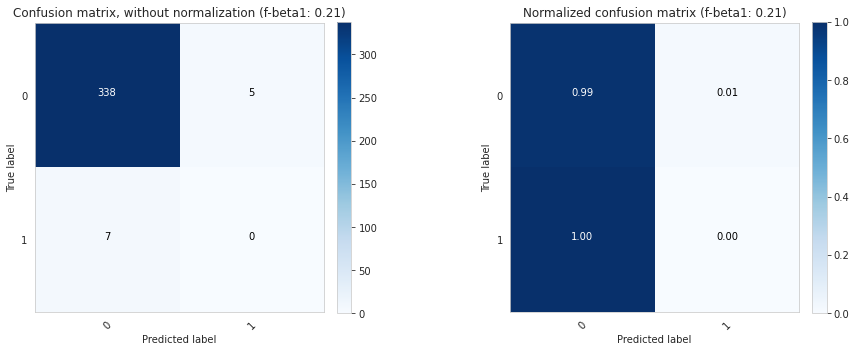

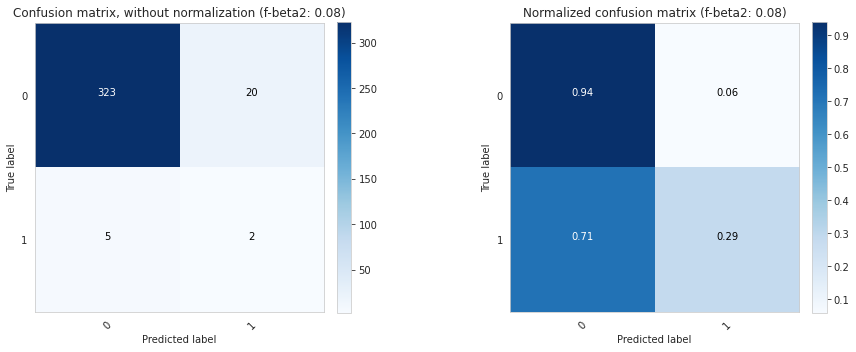



ROC Curve:


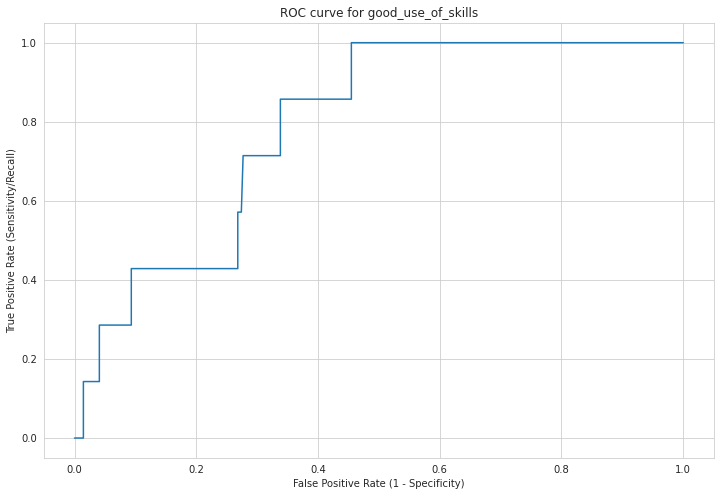

Predicted Probability Distribution:


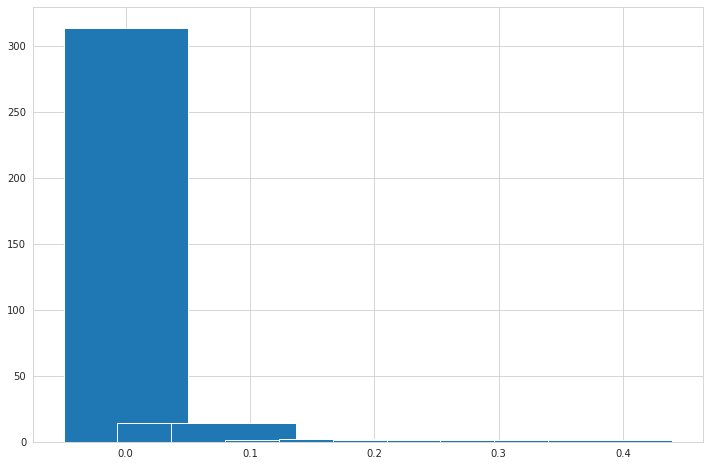



----------------------------------------------------------------------------------------------------


HAVE_NECESSARY_TOOLS

Null Accuracy:	0.9857142857142858
AUC Score:	0.9721739130434782

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.98	0.98	0.9742857142857143	
Cohen's Kappa:	0.35356200527704484	0.5242718446601942	0.45969125214408235	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9913              0.9884              0.9898              345                 
1                   0.3333              0.4                 0.3636              5                   
avg/total           0.6623              0.6942              0.6767              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9971              0.9826              0.9898              345               

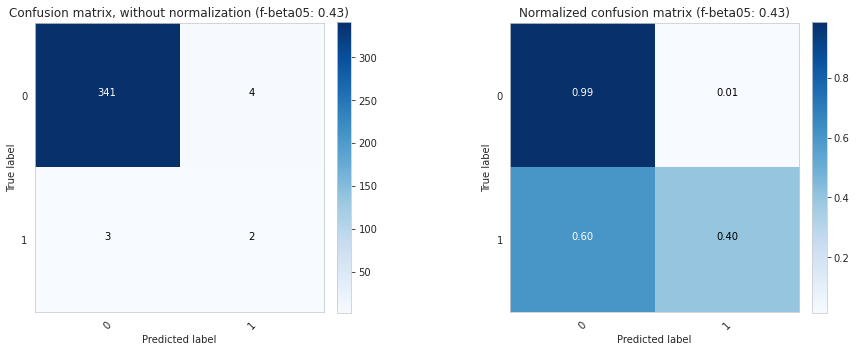

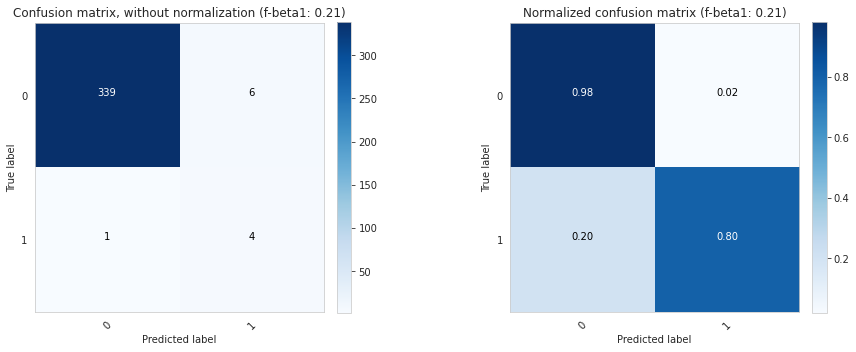

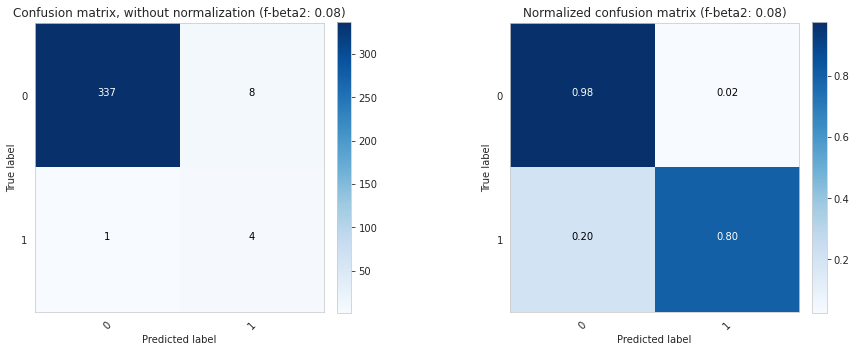



ROC Curve:


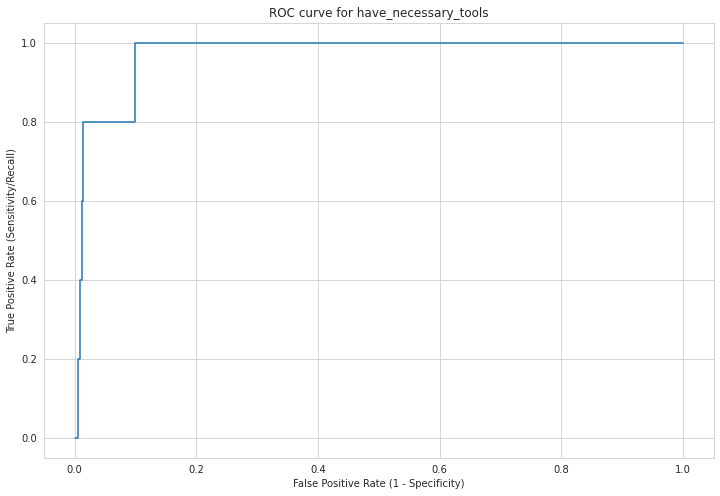

Predicted Probability Distribution:


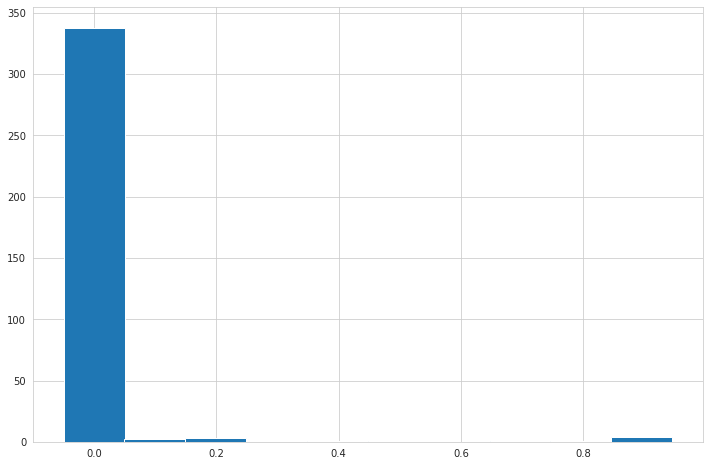



----------------------------------------------------------------------------------------------------


HAVE_VOICE_WITHIN_MY_INSTITUTION_VALUED_MEMBER_OF_MY_INSTITUTION

Null Accuracy:	0.9314285714285714
AUC Score:	0.8236196319018405

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9228571428571428	0.8828571428571429	0.8142857142857143	
Cohen's Kappa:	0.15002698327037245	0.1920954847427092	0.26731078904991956	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9384              0.9816              0.9595              326                 
1                   0.3333              0.125               0.1818              24                  
avg/total           0.6359              0.5533              0.5707              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9467

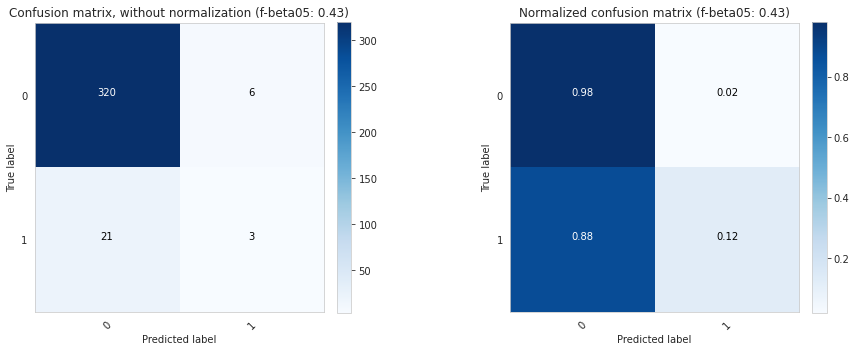

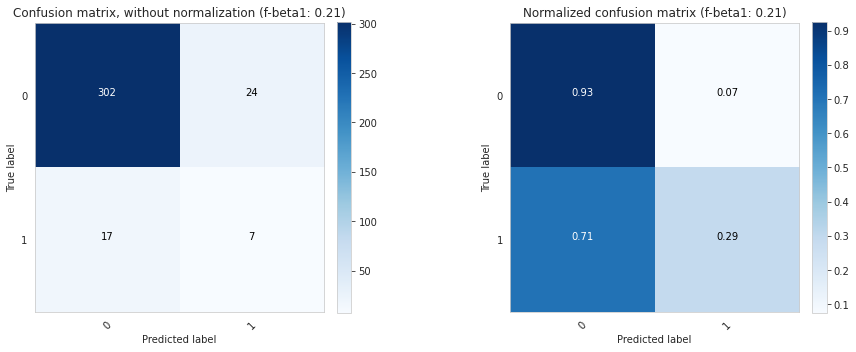

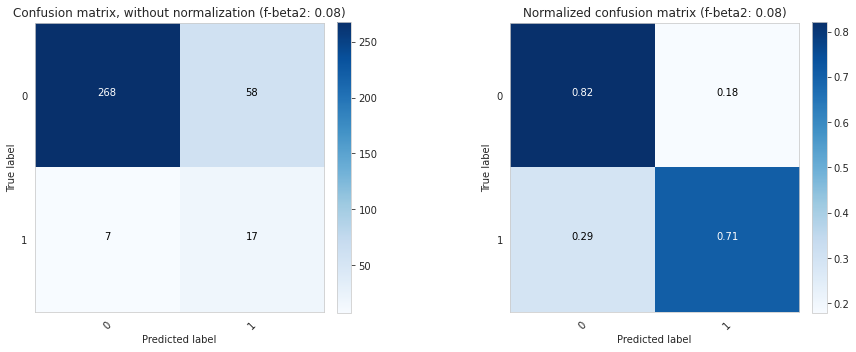



ROC Curve:


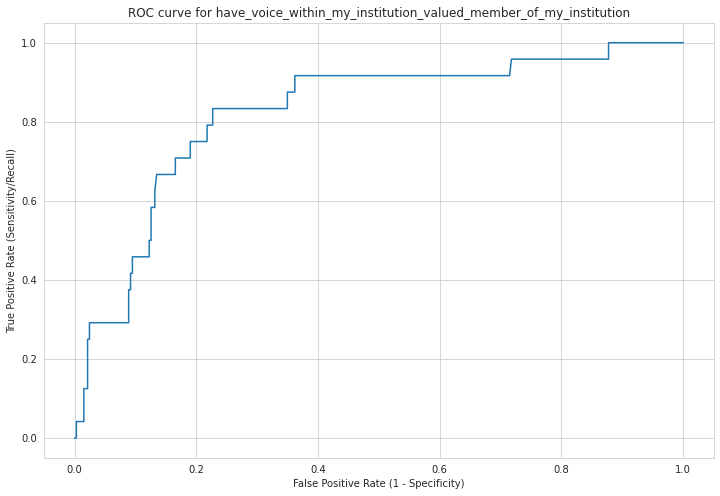

Predicted Probability Distribution:


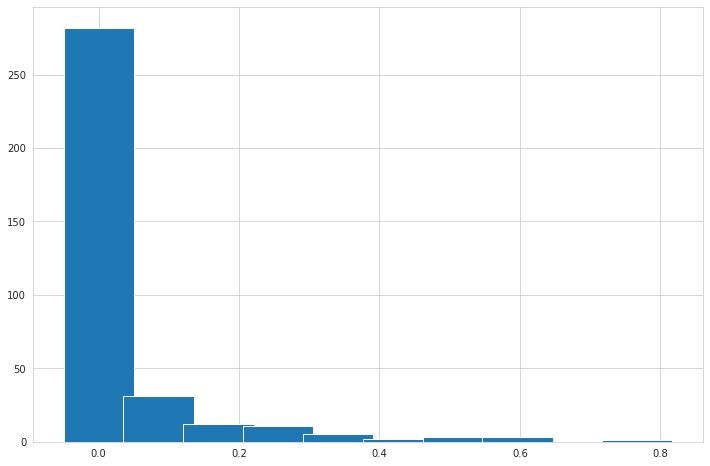



----------------------------------------------------------------------------------------------------


INTERNAL_PROCESSES_EFFECTIVE

Null Accuracy:	0.94
AUC Score:	0.8915906788247213

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.94	0.9257142857142857	0.8742857142857143	
Cohen's Kappa:	0.2953020134228187	0.3695441319107663	0.3494973388527498	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9529              0.9848              0.9686              329                 
1                   0.5                 0.2381              0.3226              21                  
avg/total           0.7265              0.6114              0.6456              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9633              0.9574              0.9604              329         

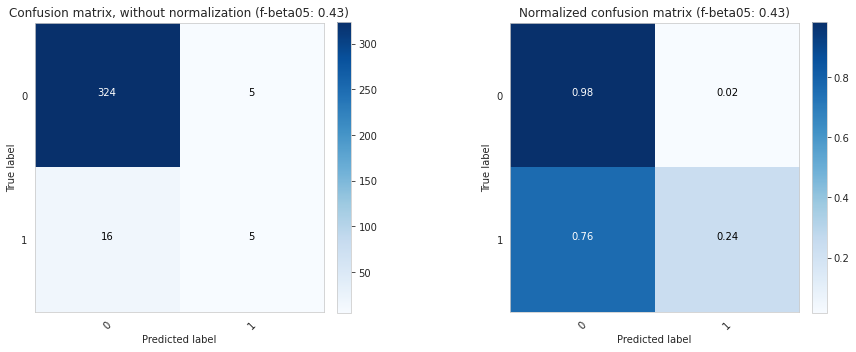

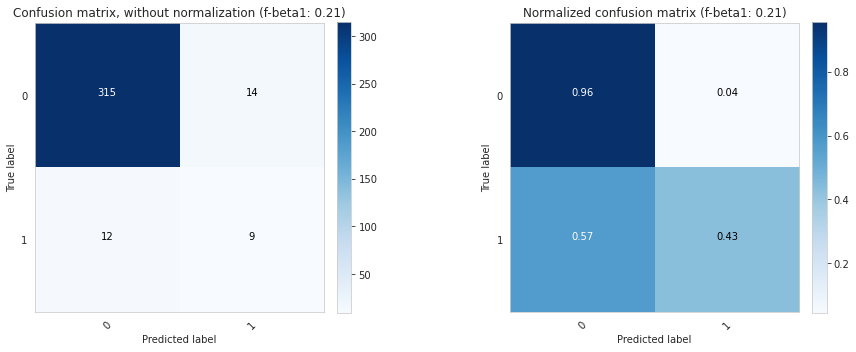

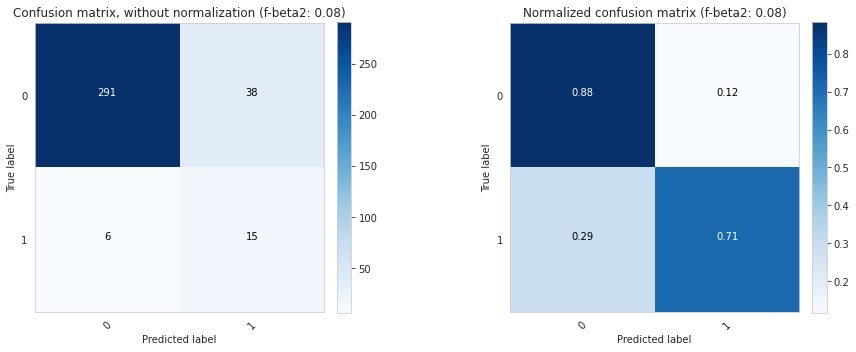



ROC Curve:


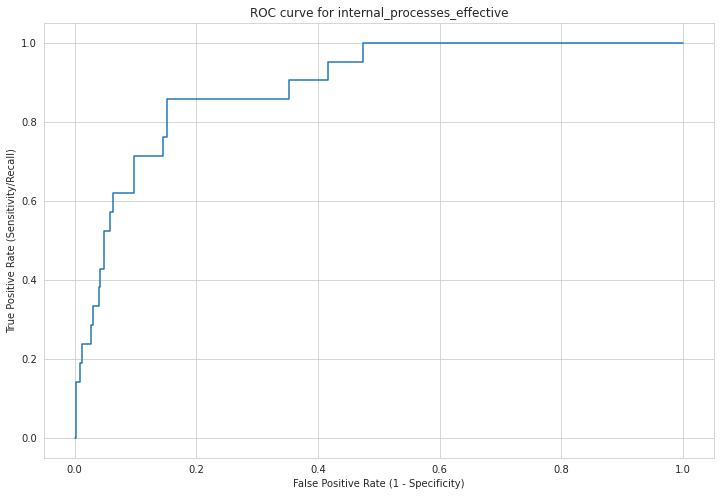

Predicted Probability Distribution:


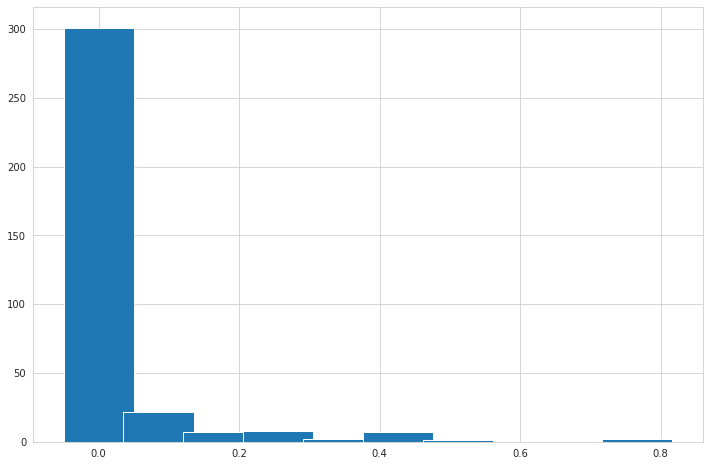



----------------------------------------------------------------------------------------------------


PARKING_TRANSPORTATION

Null Accuracy:	0.9714285714285714
AUC Score:	0.9914705882352941

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9742857142857143	0.9857142857142858	0.9828571428571429	
Cohen's Kappa:	0.45783132530120485	0.7545582047685835	0.7413793103448276	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9825              0.9912              0.9868              340                 
1                   0.5714              0.4                 0.4706              10                  
avg/total           0.777               0.6956              0.7287              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9941              0.9912              0.9926   

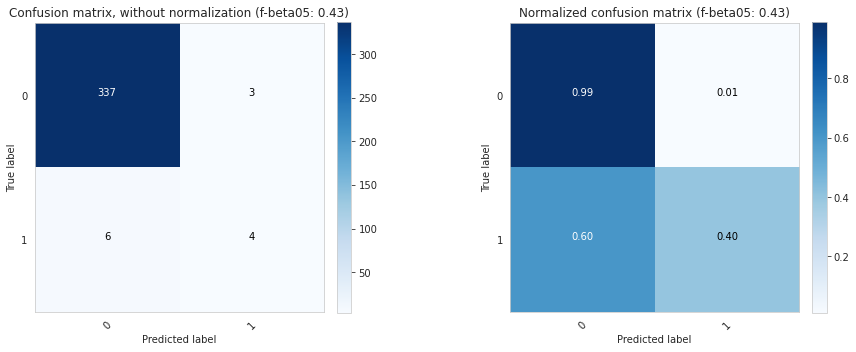

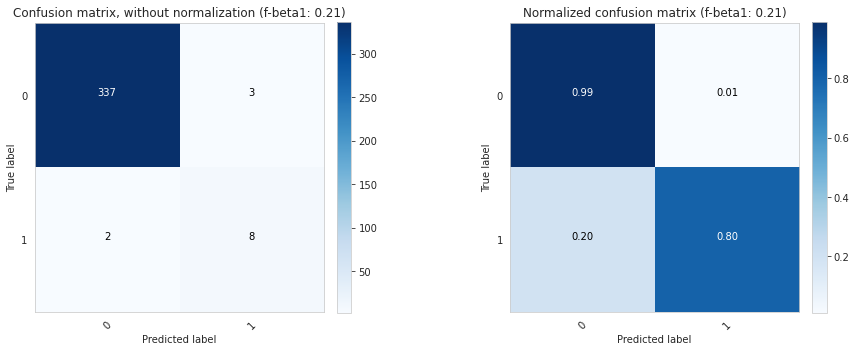

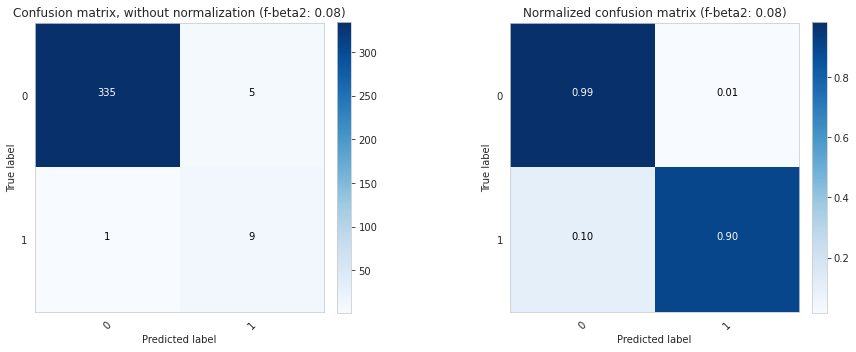



ROC Curve:


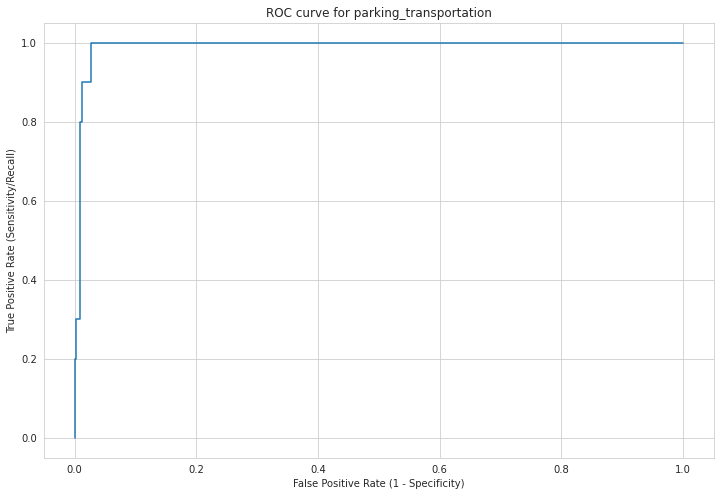

Predicted Probability Distribution:


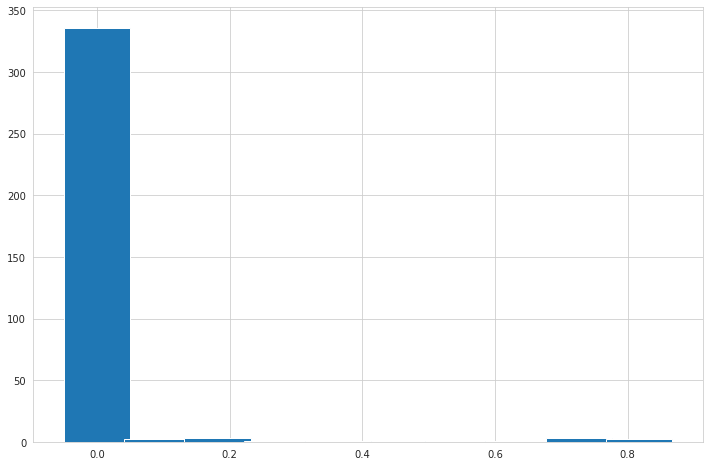



----------------------------------------------------------------------------------------------------


SALARY_PAY

Null Accuracy:	0.8657142857142858
AUC Score:	0.9106102099571659

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.8828571428571429	0.8714285714285714	0.82	
Cohen's Kappa:	0.5338790359254206	0.5735174654752233	0.47562425683709864	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9456              0.9175              0.9313              303                 
1                   0.5536              0.6596              0.6019              47                  
avg/total           0.7496              0.7885              0.7666              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9778              0.8713              0.9215              303            

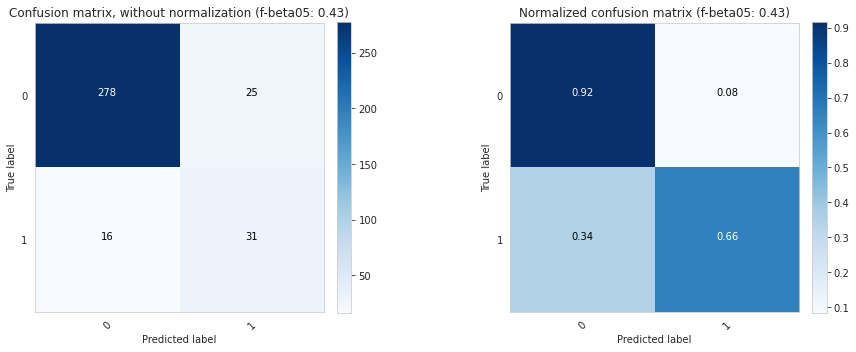

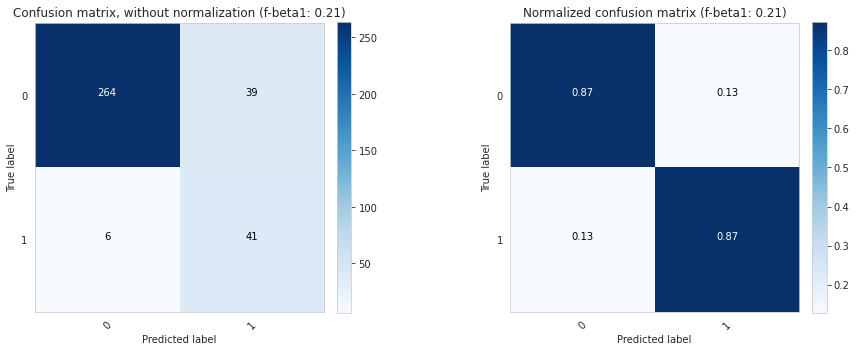

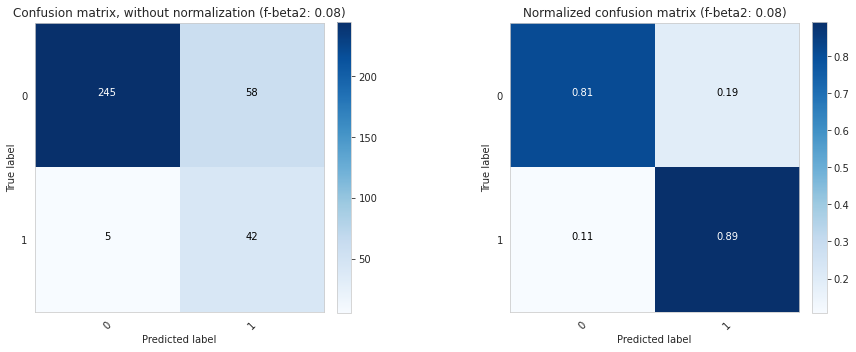



ROC Curve:


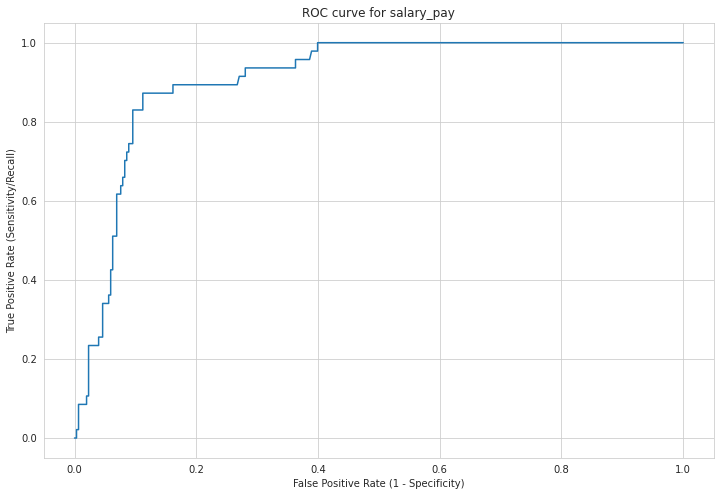

Predicted Probability Distribution:


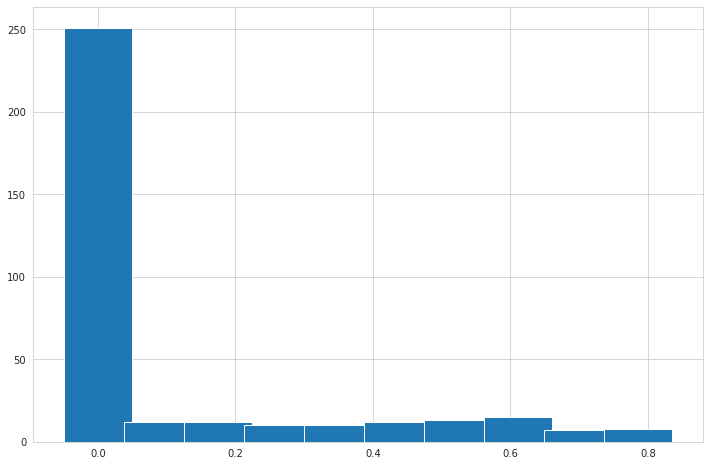



----------------------------------------------------------------------------------------------------


SATISFIED_WITH_DIVERSITY_PROGAMS

Null Accuracy:	0.92
AUC Score:	0.781055900621118

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.9228571428571428	0.8914285714285715	0.7828571428571428	
Cohen's Kappa:	0.3062692702980473	0.30758017492711376	0.21552436003303055	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9377              0.9814              0.959               322                 
1                   0.5385              0.25                0.3415              28                  
avg/total           0.7381              0.6157              0.6502              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9465              0.9348              0.9406       

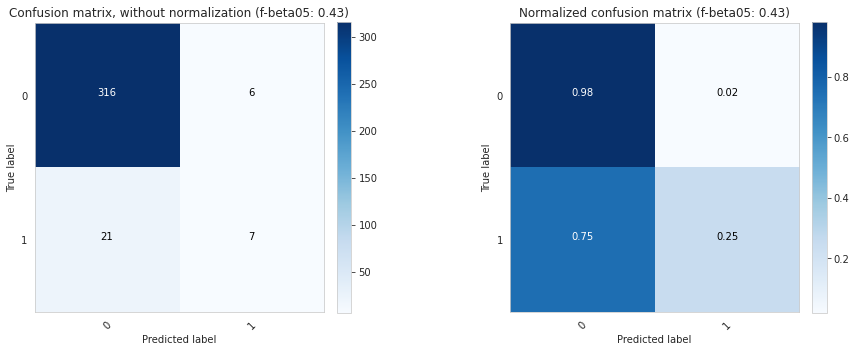

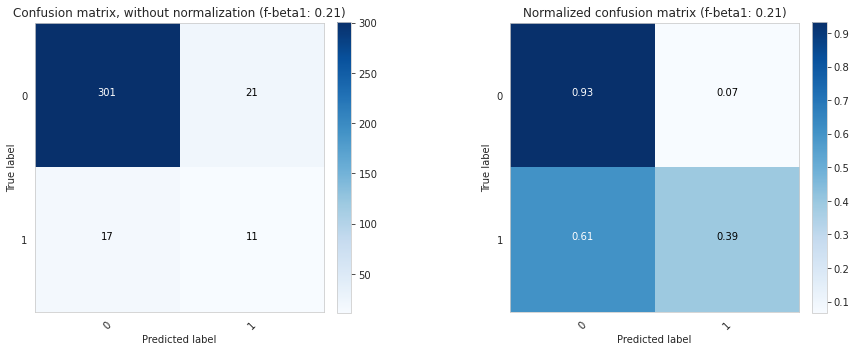

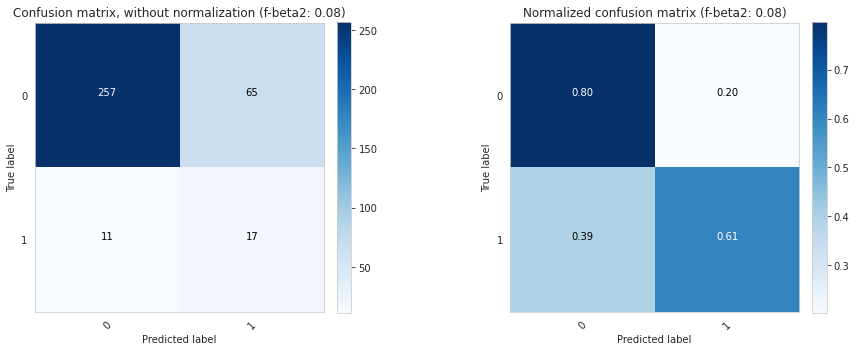



ROC Curve:


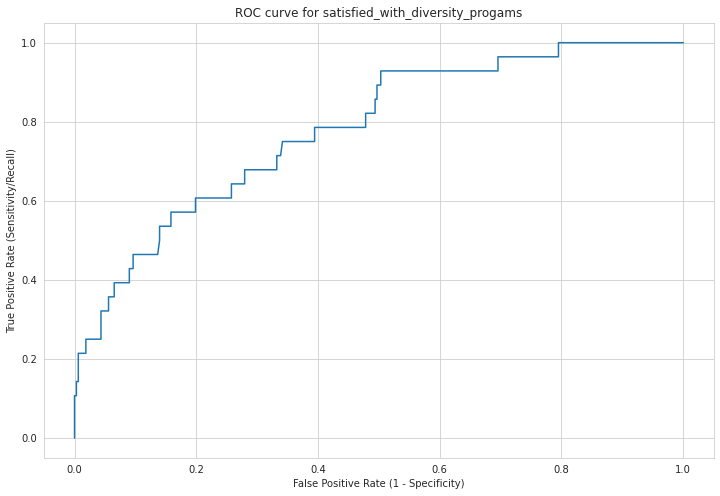

Predicted Probability Distribution:


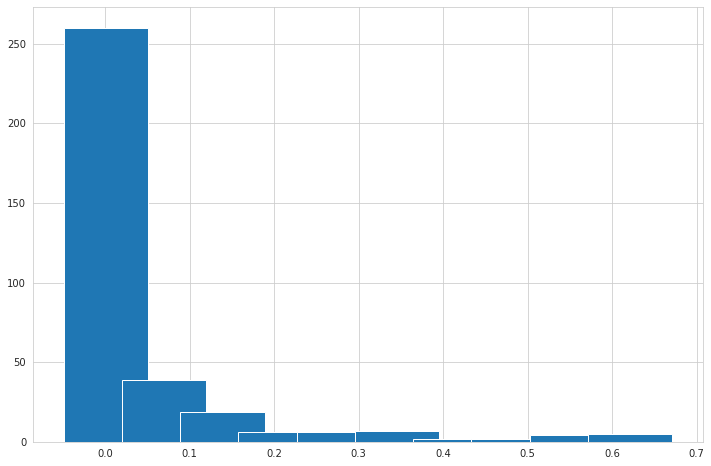



----------------------------------------------------------------------------------------------------


SUPERVISOR_EFFECTIVENESS_RESOLVES_STAFF_ISSUES

Null Accuracy:	0.8628571428571429
AUC Score:	0.8486479028697572

		f-beta05(0.43)		f-beta1(0.21)		f-beta2(0.08)
Accuracy:	0.8514285714285714	0.8371428571428572	0.6971428571428572	
Cohen's Kappa:	0.3830508474576272	0.4588509737969946	0.29825225088900664	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9167              0.9106              0.9136              302                 
1                   0.46                0.4792              0.4694              48                  
avg/total           0.6883              0.6949              0.6915              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.952               0.854

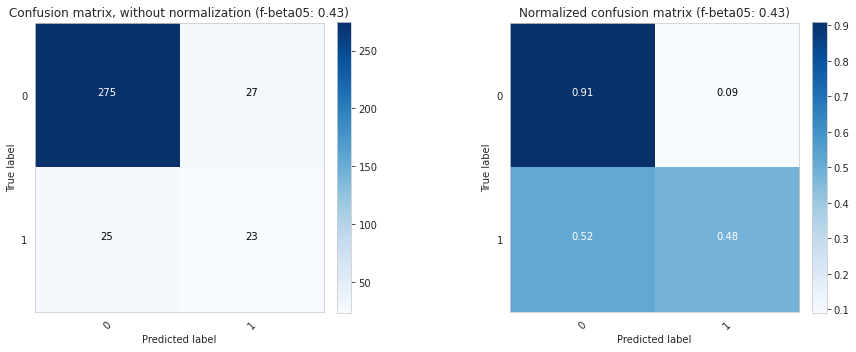

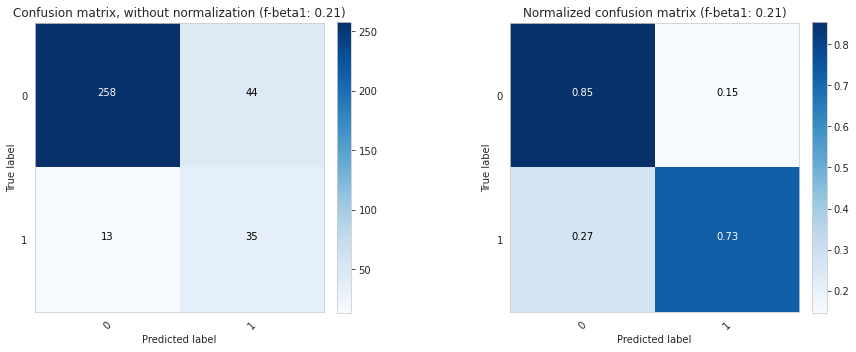

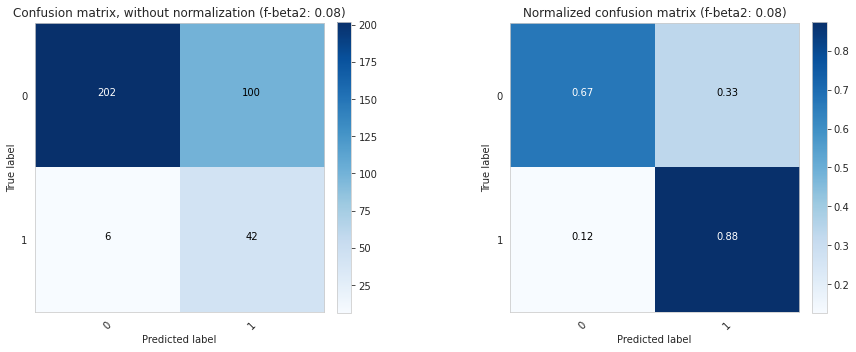



ROC Curve:


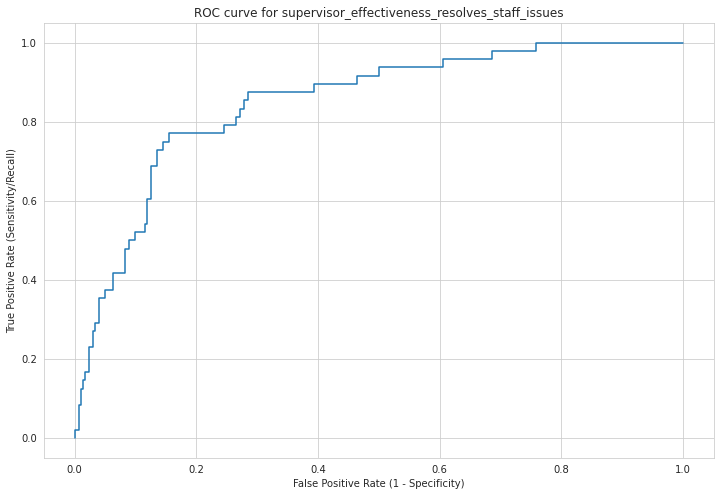

Predicted Probability Distribution:


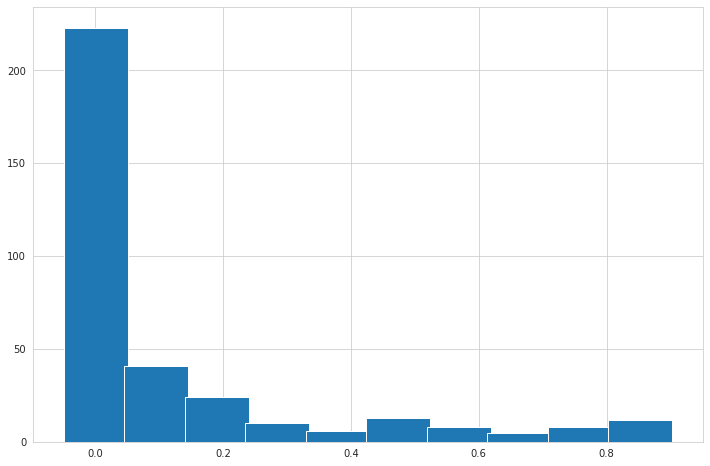



----------------------------------------------------------------------------------------------------




In [69]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Final results

In [70]:
try: del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

inf_learn = load_learner(fname=STANDARD_THEME_SAW_PATH/f'{m_pre}{base_model_name}{m_suf}_export.pkl')
inf_learn.loss_func.thresh = scores['opt_th']
dls = get_saw_standard_theme_train_dls(df, hf_arch, hf_tokenizer)
inf_learn.dls = dls

In [71]:
# inf_learn.loss_func = inf_learn.loss_func.to('cuda:1')

In [72]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs.shape, targs.shape, loss.shape

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(torch.Size([350, 25]), torch.Size([350, 25]), torch.Size([350]))

In [73]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [74]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs, targs, sigmoid=False)}')

0.45000000000000007 0.2 0.08000000000000002
Fowards Only
-------------
f05:	Optimal threshold = 0.45000000000000007	(Accuracy = 0.9314285516738892)
f1:	Optimal threshold = 0.2	(Accuracy = 0.9057142734527588)
f2:	Optimal threshold = 0.08000000000000002	(Accuracy = 0.8486857414245605)

Accuracy: 0.9324571490287781


In [75]:
final_valid_loss = loss.mean().item()

## Build our training loop for hyperparam optimization and final training

In [12]:
try: del learn; del dls
except: pass
finally: gc.collect(); torch.cuda.empty_cache()
    
yyyymmdd = datetime.today().strftime("%Y%m%d")

In [13]:
class FastAIPruningCallbackv2(TrackerCallback):
    def __init__(self, trial, monitor='valid_loss', **kwargs) -> None:
        super().__init__(monitor=monitor, **kwargs)
        self._trial = trial

    def after_epoch(self) -> None:
        super().after_epoch()
        
        value = self.recorder.values[-1][self.idx]
        if value is None: return

        self._trial.report(float(value), step=self.epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(self.epoch)
            raise optuna.TrialPruned(message)

In [14]:
#export
def train(params, trial=None, train_config={}):
          
    config = {**saw_standard_themes_train_config, **train_config}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    # 1. grab our huggingface objects
    task = HF_TASKS_AUTO.SequenceClassification
    hf_config = AutoConfig.from_pretrained(params["pretrained_model_name"])
    hf_config.num_labels = len(STANDARD_THEME_SAW_LABELS)
    
    if (f'{params["pretrained_model_name"]}_config_overrides' in params):
        hf_config.update(params[f'{params["pretrained_model_name"]}_config_overrides'])
    else:
        config_overrides = { k:v for k,v in params.items() if (k in hf_config.to_dict()) }
        hf_config.update(config_overrides)

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(params["pretrained_model_name"], 
                                                                                   task=task, 
                                                                                   config=hf_config)
    
    # 2. build our dls and learner
    df = get_saw_standard_theme_train_data(train_config=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    set_seed(TL_RAND_SEED)
    dls = get_saw_standard_theme_train_dls(df, hf_arch, hf_tokenizer, train_config=config, use_cache=False)
    
    set_seed(TL_RAND_SEED)
    learn, fit_cbs = get_learner(hf_model, 
                                 dls, 
                                 train_df=None, 
                                 use_weighted_loss=params["use_weighted_loss"], 
                                 use_fp16=params["use_fp16"],
                                 add_save_model_cb=params['save_model'],
                                 train_config=config)
    
    if (trial is not None): learn.add_cb(FastAIPruningCallbackv2(trial=trial, monitor=params['optimize_for']))
    
    # 3. train
    with learn.no_logging(): 
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_frozen_epochs"], lr_max=params["frozen_lr"], cbs=fit_cbs)
        
        learn.unfreeze()
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_unfrozen_epochs"], 
                            lr_max=slice(params["unfrozen_lr_min"], params["unfrozen_lr_max"]), 
                            cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model if save_mode=True)
        if (trial is None): learn.export(fname=f"{yyyymmdd}_{config['export_filename']}")
            
    # 4. evaluate
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]])))
    
    try:
        if (trial is not None): return scores[params['optimize_for']]
        
        learn.loss_func.thresh = scores['opt_th']
        probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)

        # determine optimal threshold based on desired f-score
        average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

        f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)

        scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}

        scores['f05']['threshold'] = f05.opt_th(probs, targs)
        scores['f1']['threshold'] = f1.opt_th(probs, targs)
        scores['f2']['threshold'] = f2.opt_th(probs, targs)

        scores['f05']['score'] = f05.opt_fscore(probs, targs)
        scores['f1']['score'] = f1.opt_fscore(probs, targs)
        scores['f2']['score'] = f2.opt_fscore(probs, targs)
    
        # save scores from validation set if mode == training (i.e., trial == None)
        with open(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json", 'w') as f:
            json.dump(scores, f, indent=4)
        
        # save train/validation probs, targs, losses for review
        test_dl = dls.test_dl(df, with_labels=True)
        probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)

        probs_df = pd.DataFrame(probs.numpy(), columns=['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS])
        targs_df = pd.DataFrame(targs.numpy(), columns= ['targ_' + lbl for lbl in STANDARD_THEME_SAW_LABELS])
        losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
        final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)

        final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_results.csv", index=False)
        return scores, final_df
    
    finally:
        # cleanup
        del learn; del dls 
        del hf_arch; del hf_config; del hf_tokenizer; del hf_model

### Hyperparameter optimization

In [15]:
def after_trial_cleanup(study, trial):
    gc.collect()
    torch.cuda.empty_cache()

In [16]:
#export
def objective(trial, train_config={}):
    opt_params = {
        'pretrained_model_name': trial.suggest_categorical("pretrained_model_name", ["facebook/bart-base"]),
        
        'save_model': trial.suggest_categorical("save_model", [True, False]), 
        'use_weighted_loss': trial.suggest_categorical("use_weighted_loss", [False]),
        'use_fp16': trial.suggest_categorical("use_fp16", [True]),
        'n_frozen_epochs': trial.suggest_int("n_frozen_epochs", 1, 5),
        'n_unfrozen_epochs': trial.suggest_int("n_unfrozen_epochs", 0, 10),
        'frozen_lr': trial.suggest_loguniform("frozen_lr", 2e-4, 2e-2),
        'unfrozen_lr_max': trial.suggest_loguniform("unfrozen_lr_max", 3e-7, 3e-6),
        'unfrozen_lr_min': trial.suggest_loguniform("unfrozen_lr_min",3e-8, 3e-7),
        'optimize_for': 'precision_score',
        
        'facebook/bart-base_config_overrides': {
            'activation_dropout': trial.suggest_discrete_uniform('activation_dropout', 0.0, 0.3, 0.05),
            'attention_dropout': trial.suggest_discrete_uniform('attention_dropout', 0.0, 0.3, 0.05),
            'classif_dropout': trial.suggest_discrete_uniform('classif_dropout', 0.0, 0.3, 0.05),
            'dropout': trial.suggest_discrete_uniform('dropout', 0.0, 0.3, 0.05)
        },
        'roberta-base_config_overrides': {
            'attention_probs_dropout_prob': trial.suggest_discrete_uniform('attention_probs_dropout_prob', 0.0, 0.3, 0.05),
            'hidden_dropout_prob': trial.suggest_discrete_uniform('hidden_dropout_prob', 0.0, 0.3, 0.05)
        }
    }
    
    score = train(opt_params, trial=trial, train_config=train_config)
    return score

In [17]:
start = datetime.now()

pruner = optuna.pruners.MedianPruner() if True else optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)

train_config = {}
study.optimize(partial(objective, train_config=train_config), 
               n_trials=30, 
               callbacks=[after_trial_cleanup])#, timeout=600)

end = datetime.now()

[I 2020-10-23 23:10:53,471] A new study created in memory with name: no-name-e41296f1-5377-4738-80d1-91a1e521d9ef


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.016940604827392645.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.03805606230704463.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with precision_score value: 0.05082619983160258.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.05609081181588549.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Better model found at epoch 5 with precision_score value: 0.059958690008419864.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgi

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 00:08:08,109] Trial 2 finished with value: 0.47428728665656444 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 8, 'frozen_lr': 0.004772075315793604, 'unfrozen_lr_max': 5.272509303407106e-07, 'unfrozen_lr_min': 1.6932660126034524e-07, 'activation_dropout': 0.2, 'attention_dropout': 0.1, 'classif_dropout': 0.25, 'dropout': 0.2, 'attention_probs_dropout_prob': 0.3, 'hidden_dropout_prob': 0.05}. Best is trial 1 with value: 0.4911786713294229.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/wgi

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
I

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgi

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgi

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 05:41:17,921] Trial 28 finished with value: 0.5852319256737154 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 10, 'frozen_lr': 0.0009149609157871275, 'unfrozen_lr_max': 1.045742032946752e-06, 'unfrozen_lr_min': 1.5564982020840343e-07, 'activation_dropout': 0.1, 'attention_dropout': 0.05, 'classif_dropout': 0.05, 'dropout': 0.15000000000000002, 'attention_probs_dropout_prob': 0.05, 'hidden_dropout_prob': 0.1}. Best is trial 21 with value: 0.5971789512559447.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.45390661930081044.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 05:44:06,184] Trial 29 pruned. Trial was pruned at epoch 1.


In [18]:
m_pre, m_suf = saw_standard_themes_train_config['m_pre'], saw_standard_themes_train_config['m_suf']
full_model_name = f"{m_pre}{saw_standard_themes_train_config['base_model_name']}{m_suf}"

pruned_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED ]
complete_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE ]

print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items(): print('    {}: {}'.format(key, value))
print('  User attrs:')
for key, value in trial.user_attrs.items(): print('    {}: {}'.format(key, value))
    
best_params = study.best_params
best_params['precision_score'] = study.best_value

with open(f"{saw_standard_themes_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json", 'w') as f:
    json.dump(best_params, f, indent=4)

trials_df = study.trials_dataframe()
trials_df.to_csv(f"{saw_standard_themes_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_trial_results.csv", 
                 index=False)

print(f'total time is {(end - start).total_seconds()} seconds')

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  14
  Number of complete trials:  16
Best trial:
  Value:  0.5971789512559447
  Params: 
    pretrained_model_name: facebook/bart-base
    save_model: False
    use_weighted_loss: False
    use_fp16: True
    n_frozen_epochs: 4
    n_unfrozen_epochs: 8
    frozen_lr: 0.000868066509114298
    unfrozen_lr_max: 1.327514351781446e-06
    unfrozen_lr_min: 7.019562906059298e-08
    activation_dropout: 0.3
    attention_dropout: 0.05
    classif_dropout: 0.25
    dropout: 0.05
    attention_probs_dropout_prob: 0.1
    hidden_dropout_prob: 0.05
  User attrs:
total time is 23592.961883 seconds


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/optuna/structs.py:21: FutureWarning: `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.
  warnings.warn(_message, FutureWarning)


### Training with best params

In [19]:
with open(f"{saw_standard_themes_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json") as f: 
    best_params = json.load(f)
    
scores, train_res_df = train(params=best_params, train_config={})

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
scores

{'valid_loss': 0.15935730934143066,
 'accuracy_multi': 0.9394894242286682,
 'fbeta_score': 0.5215310512683625,
 'precision_score': 0.5971789512559447,
 'recall_score': 0.38392857142857145,
 'roc_auc_score': 0.6795381734154169,
 'opt_th': 0.4199999999999999,
 'f05': {'threshold': 0.42000000000000004, 'score': 0.5215310512683625},
 'f1': {'threshold': 0.2, 'score': 0.5235521899808544},
 'f2': {'threshold': 0.13, 'score': 0.6126632330505484}}

In [21]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_within_my_institution_valued_member_of_my_institution,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues,labels,is_valid,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,targ_adequate_staffing,targ_advancement_and_training_opportunities,targ_appropriate_stress_work_assigned_equitably,targ_benefits,targ_better_ways_recognized_participate_in_decisions,targ_career_advancement,targ_committed_to_diversity,targ_communicates_essential_information,targ_ethical_conduct_perform_responsibilities_spirit_of_cooperation,targ_evaluated_fairly,targ_experienced_discrimination,targ_facilities_workspace_safety,targ_faculty_value_contributions,targ_favoritism_cliques,targ_fear_of_retaliation_negative_consequences,targ_feel_valued_by_department,targ_flexibility_work_life_balance,targ_good_use_of_skills,targ_have_necessary_tools,targ_have_voice_within_my_institution_valued_member_of_my_institution,targ_internal_processes_effective,targ_parking_transportation,targ_salary_pay,targ_satisfied_with_diversity_progams,targ_supervisor_effectiveness_resolves_staff_issues,loss
0,0,589315,1877,"From day one, my department and colleagues made me feel welcomed. Most importantly, I sincerely ...",NaN,English,212,9,SAW,UCSD,451357,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11926.0,3267,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10017.0,EVC,11926.0,EVC - TEACHING + LEARNING COMMONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ethical_conduct_perform_responsibilities_spirit_of_cooperation feel_valued_by_department,False,0.045353,0.028328,0.052038,0.002492,0.078219,0.010449,0.009232,0.002924,0.198064,0.001427,0.040769,0.002611,0.473703,0.001768,0.002051,0.839865,0.003780,0.041153

In [22]:
# load scores
with open(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_{full_model_name}_train_scores.json') as f: 
    training_results = json.load(f)
    
training_results

{'valid_loss': 0.15935730934143066,
 'accuracy_multi': 0.9394894242286682,
 'fbeta_score': 0.5215310512683625,
 'precision_score': 0.5971789512559447,
 'recall_score': 0.38392857142857145,
 'roc_auc_score': 0.6795381734154169,
 'opt_th': 0.4199999999999999,
 'f05': {'threshold': 0.42000000000000004, 'score': 0.5215310512683625},
 'f1': {'threshold': 0.2, 'score': 0.5235521899808544},
 'f2': {'threshold': 0.13, 'score': 0.6126632330505484}}

In [23]:
inf_learn = load_learner(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_{full_model_name}_export.pkl')
inf_learn.loss_func.thresh = scores['opt_th']

print(inf_learn.loss_func.thresh)
print(inf_learn.blurr_predict('We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued"))

0.4199999999999999


((#2) ['benefits','salary_pay'], tensor([False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False]), tensor([0.0111, 0.0180, 0.0120, 0.6428, 0.0029, 0.0143, 0.0020, 0.0048, 0.0136,
        0.0043, 0.0061, 0.0016, 0.0021, 0.0011, 0.2851, 0.0474, 0.0173, 0.0016,
        0.0008, 0.0087, 0.0056, 0.0092, 0.5656, 0.0072, 0.0142]))


((#2) ['faculty_value_contributions','feel_valued_by_department'], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False, False, False, False, False]), tensor([9.6774e-02, 6.7579e-03, 2.3350e-02, 4.2362e-03, 5.5053e-02, 1.2190e-03,
        5.6599e-03, 9.8380e-04, 1.9646e-01, 1.2288e-03, 1.6335e-02, 7.9903e-04,
        6.2849e-01, 1.1867e-03, 2.0563e-03, 6.0847e-01, 5.4021e-03, 6.2996e-03,
        4.4006e-04, 1.3796e-01, 3.5937e-03, 6.1820e-04, 7.1128e-03, 4.1112e-02,
        2.2729e-02]))


## Inference

### Inference (ad-hoc documents)

In [24]:
print(STANDARD_THEME_SAW_LABELS)

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions', 'career_advancement', 'committed_to_diversity', 'communicates_essential_information', 'ethical_conduct_perform_responsibilities_spirit_of_cooperation', 'evaluated_fairly', 'experienced_discrimination', 'facilities_workspace_safety', 'faculty_value_contributions', 'favoritism_cliques', 'fear_of_retaliation_negative_consequences', 'feel_valued_by_department', 'flexibility_work_life_balance', 'good_use_of_skills', 'have_necessary_tools', 'have_voice_within_my_institution_valued_member_of_my_institution', 'internal_processes_effective', 'parking_transportation', 'salary_pay', 'satisfied_with_diversity_progams', 'supervisor_effectiveness_resolves_staff_issues']


In [25]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!",
    "Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c, with_input=True))

(HF_BaseInput([   0, 1491, 1199,  615,    4,    2]), (#1) ['salary_pay'], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False]), tensor([0.0094, 0.0217, 0.0187, 0.0131, 0.0033, 0.0078, 0.0027, 0.0041, 0.0200,
        0.0089, 0.0049, 0.0022, 0.0031, 0.0044, 0.3506, 0.0146, 0.0016, 0.0013,
        0.0009, 0.0036, 0.0092, 0.0164, 0.7278, 0.0061, 0.0135]))


(HF_BaseInput([    0,    38,   524, 10028,    19,   127,  1795,     8,    52,    33,
          615,    82,    11,   127,  1494,     4,    20,  7998,    16,  1266,
            7,   162,     4,     2]), (#2) ['faculty_value_contributions','feel_valued_by_department'], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False, False, False, False, False]), tensor([2.8037e-01, 9.0520e-03, 3.1406e-02, 7.7537e-02, 7.7237e-02, 3.6471e-03,
        8.5562e-03, 1.4272e-03, 7.5098e-02, 2.7469e-03, 1.4472e-02, 4.8772e-04,
        7.3806e-01, 2.1039e-03, 3.2164e-02, 6.6231e-01, 1.1809e-02, 5.4492e-03,
        5.9346e-04, 4.8953e-02, 2.5335e-03, 3.0834e-03, 1.3623e-01, 1.1539e-02,
        2.4736e-02]))


(HF_BaseInput([    0,    38,   657, 10017,     2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]), tensor([0.0204, 0.0017, 0.0042, 0.0014, 0.0050, 0.0020, 0.0113, 0.0008, 0.1018,
        0.0009, 0.0339, 0.0027, 0.0198, 0.0114, 0.0109, 0.1721, 0.0030, 0.0041,
        0.0002, 0.0156, 0.0006, 0.0013, 0.0041, 0.0463, 0.0098]))


(HF_BaseInput([    0,    38,    64,   393,   465,    10,  2932,  1514,     4,    20,
         2572,    90,  1634,    32,    45,    15,    86,     4, 10310,     2]), (#1) ['parking_transportation'], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False]), tensor([0.0626, 0.0055, 0.0039, 0.0010, 0.0095, 0.0044, 0.0039, 0.0092, 0.0507,
        0.0009, 0.0081, 0.0036, 0.0064, 0.0041, 0.0048, 0.0132, 0.0079, 0.0020,
        0.0029, 0.0040, 0.0303, 0.8643, 0.0026, 0.0061, 0.0094]))


(HF_BaseInput([    0,    38,    21,   269,  9800,     7,  5486,   127,  2979, 16506,
            2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]), tensor([0.0025, 0.0038, 0.0017, 0.0004, 0.0394, 0.0030, 0.0196, 0.0022, 0.0434,
        0.0015, 0.2436, 0.0025, 0.0115, 0.0026, 0.0728, 0.1580, 0.0003, 0.0025,
        0.0004, 0.0736, 0.0010, 0.0010, 0.0049, 0.0607, 0.0129]))


(HF_BaseInput([    0,  2321,  8914,   890,    16,    41,  9297,   884,     4,  1437,
           91,    34,  1613,  1065,     8,  1684,     7,  1045,    10,  1313,
          447,  1737,     8,   694,   434,  1616,     4,  1437,   832,  2720,
            7,    39,   165,    16,   542, 27978,   196,     8, 19781,   868,
            4, 37457,   338, 37457,   282, 37457,   338, 37457,   282, 38334,
         3144,  5302,  2478,    16,    10,  1421,     9, 12757,  1673,    13,
         6919,     8, 37513,  1630,  2617,  1820,     4,  1437,   264,    34,
         2208,     5,  2098,     9,   167,    79,  3315,   149,  5322,  4358,
            6, 17805,     6,     8, 13557,  9434,     4,     2]), (#2) ['faculty_value_contributions','supervisor_effectiveness_resolves_staff_issues'], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False,  True]), tensor([3.0492e

### Inference (batch)

In [26]:
#export
def get_standard_theme_preds(inf_df, learner_export_path=None, train_scores_path=None, yyyymmdd=None,
                             device=torch.device('cpu'), train_config={}):
    
    config = {**saw_standard_themes_train_config, **train_config}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    if (yyyymmdd is None): yyyymmdd = datetime.today().strftime("%Y%m%d")
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    if (learner_export_path is None): 
        learner_export_path = f"{config['learner_path']}/{yyyymmdd}_{config['export_filename']}"
    if (train_scores_path is None): 
        train_scores_path = f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json"
        
    with open(train_scores_path) as f: training_results = json.load(f)
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.loss_func.thresh = training_results['opt_th']
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df.dropna(subset=config['corpus_cols'], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs = []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = torch.sigmoid(inf_learn.model(b[0])[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))

    all_probs = L(torch.cat(test_probs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. add model scores
    prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS]
    probs_df = pd.DataFrame(all_probs.numpy(), columns=prob_labels)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    
    for lbl in STANDARD_THEME_SAW_LABELS:
        final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > training_results['opt_th']).astype(np.int64)
        
    final_df['valid_loss'] = training_results['valid_loss']
    final_df['accuracy_multi'] = training_results['accuracy_multi']
    final_df['fbeta_score'] = training_results['fbeta_score']
    final_df['precision_score'] = training_results['precision_score']
    final_df['recall_score'] = training_results['recall_score']
    final_df['roc_auc_score'] = training_results['roc_auc_score']
    final_df['opt_th'] = training_results['opt_th']
    final_df['f05_threshold'] = training_results['f05']['threshold']
    final_df['f05_score'] = training_results['f05']['score']
    final_df['f1_threshold'] = training_results['f1']['threshold']
    final_df['f1_score'] = training_results['f1']['score']
    final_df['f2_threshold'] = training_results['f2']['threshold']
    final_df['f2_score'] = training_results['f2']['score']

    # cleanup
    try: del inf_learn; del inf_dl
    except: pass
    finally: gc.collect(); torch.cuda.empty_cache()
    
    return final_df, all_probs, STANDARD_THEME_SAW_LABELS

In [27]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

inf_df['answer_text'] = inf_df['AnswerText']  # ['question_text', 'answer_text']

591447 4045


In [30]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, inf_probs, inf_labels = get_standard_theme_preds(inf_df, device=device, yyyymmdd=20201023)
print(preds_df.shape, inf_probs.shape, len(inf_labels))

cuda:1
0
(4045, 102) torch.Size([4045, 25]) 25


In [31]:
preds_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_within_my_institution_valued_member_of_my_institution,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,f05_threshold,f05_score,f1_threshold,f1_score,f2_threshold,f2_score
0,589996,2576,"no, I do not want to elaborate on my answers out fear of reprisal",NaN,English,212,9,SAW,UCSD,451417,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,17.0,3729,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,802.0,FACILITIES MANAGEMENT,17.0,FLEET SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"no, I do not want to elaborate on my answers out fear of reprisal",0.004954,0.005993,0.000977,0.000304,0.008047,0.004383,0.005733,0.040012,0.066766,0.002650,0.053669,0.005162,0.004520,0.004568,0.490196,0.020605,0.000227,0.000874,0.001234,0.010666,0.003131,0.000303,0.009225,0.006580,0.020697,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.159357,0.939489,0.521531,0.597179,0.383929,0.679538,0.42,0.42,0.521531,0.2,0.523552,0.13,0.612663
1,591624,9440,I would highlight Randy Leopold. He exemplifies the Mission Statement of UCSD and of our depart...,NaN,English,212,9,SAW,UCSD,449570,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,50712.0,4753,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,50100.0,"CAPITAL PROGRAM MANAGEMENT, DESIGN & DEVELOPMENT SERVICES",50710.0,CAPITAL PROGRAM MANAGEMENT,50712.0,CAPITAL PROGRAM MANAGEMENT STAFF,NaN,NaN,NaN,NaN,NaN,NaN,I would highlight Randy Leopold. He exem

In [32]:
yyyymmdd = datetime.today().strftime("%Y%m%d")
preds_df.to_csv(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_test_predictions{m_suf}.csv', index=False)

*If we were building results DataFrame by hand ...*

Add the probabilities of each label to `inf_df`

In [33]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS]
probs_df = pd.DataFrame(inf_probs.numpy(), columns=prob_labels)
probs_df.head()

,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues
0,0.004954,0.005993,0.000977,0.000304,0.008047,0.004383,0.005733,0.040012,0.066766,0.002650,0.053669,0.005162,0.004520,0.004568,0.490196,0.020605,0.000227,0.000874,0.001234,0.010666,0.003131,0.000303,0.009225,0.006580,0.020697
1,0.074572,0.003058,0.020067,0.000455,0.352203,0.001658,0.045278,0.012785,0.070587,0.001633,0.015060,0.002021,0.190290,0.001519,0.013214,0.379845,0.029185,0.003797,0.000718,0.135858,0.004889,0.000236,0.001459,0.043052,0.777514
2,0.024720,0.003806,0.002119,0.002571,0.003224,0.001450,0.009321,0.001110,0.023994,0.000909,0.046998,0.014270,0.018532,0.001432,0.002238,0.017337,0.012908,0.004300,0.000238,0.003817,0.004308,0.001071,0.001204,0.035091,0.082026
3,0.007060,0.081343,0.049458,0.009681,0.006199,0.171115,0.002953,0.005459,0.020059,0.033035,0.033031,0.002240,0.019890,0.009771,0.377936,0.076803,0.002772,0.003735,0.002195,0.019867,0.005776,0.001699,0.811998,0.004752,0.006511
4,0.009925,0.299962,0.049316,0.013867,0.001998,0.567637,0.007414,0.000744,0.008029,0.000924,0.010380,0.097835,0.002854,0.000945,0.010352,0.009095,0.025750,0.021292,0.000565,0.005695,0.006573,0.000137,0.185036,0.017627,0.008815


In [34]:
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f05 threshold

In [35]:
for lbl in STANDARD_THEME_SAW_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > scores['opt_th']).astype(np.int64)

In [36]:
final_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_within_my_institution_valued_member_of_my_institution,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues
0,589996,2576,"no, I do not want to elaborate on my answers out fear of reprisal",NaN,English,212,9,SAW,UCSD,451417,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,17.0,3729,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,802.0,FACILITIES MANAGEMENT,17.0,FLEET SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"no, I do not want to elaborate on my answers out fear of reprisal",0.004954,0.005993,0.000977,0.000304,0.008047,0.004383,0.005733,0.040012,0.066766,0.002650,0.053669,0.005162,0.004520,0.004568,0.490196,0.020605,0.000227,0.000874,0.001234,0.010666,0.003131,0.000303,0.009225,0.006580,0.020697,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,591624,9440,I would highlight Randy Leopold. He exemplifies the Mission Statement of UCSD and of our depart...,NaN,English,212,9,SAW,UCSD,449570,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,50712.0,4753,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,50100.0,"CAPITAL PROGRAM MANAGEMENT, DESIGN & DEVELOPMENT SERVICES",50710.0,CAPITAL PROGRAM MANAGEMENT,50712.0,CAPITAL PROGRAM MANAGEMENT STAFF,NaN,NaN,NaN,NaN,NaN,NaN,I would highlight Randy Leopold. He exemplifies the Mission Statement of UCSD and of our depart...,0.074572,0.003058,0.020067,0.000455,0.352203,0.001658,0.045278,0.012785,0.070587,0.001633,0.015060,0.002021,0.190290,0.001519,0.013214,0.379845,0.029185,0.003797,0.000718,0.135858,0.004889,0.000236

## Cleanup

In [37]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 02a_verbatims-core.ipynb.
Converted 02b_verbatims-sentiment.ipynb.
Converted 02c_verbatims-standard-themes-saw-training.ipynb.
Converted 02d_verbatims-standard-themes-css-training.ipynb.
Converted 02e_verbatims-standard-themes-meta-training.ipynb.
Converted 99_verbatims-inference.ipynb.
Converted index.ipynb.


## Playground

In [38]:
verbatim_id = 590946

pred_lbls = [ f'pred_{lbl}' for lbl in STANDARD_THEME_SAW_LABELS ]
prob_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_SAW_LABELS ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print([ pred_lbls[idx] for idx in np.where(preds == 1)[0] ])
print('\n=== probs ===')
probs = preds_df[prob_lbls][preds_df.Id == verbatim_id].values[0]
print([ probs[idx] for idx in np.where(preds == 1)[0] ])

=== text ===
Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\r\n\r\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation.

=== preds ===
['pred_faculty_value_contributions', 'pred_supervisor_effectiveness_resolves_staff_issues']

=== probs ===
[0.4477822, 0.8580274]
